# Exploración de datos - Estación de Quintero

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os

project_path = os.path.abspath('../')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.eda.processing import get_SO2_peaks, get_SO2_limit, filter_by_dates, dates_to_hours, to_season, daily_stats, df_counts
from src.eda.visualization import hist_plot, conf_matrix, lag_plot, plot_peak_counts,\
                                    plot_temp, cumdistr_comparison, cumdistr_comparacion_horaria
from src.eda.trends import *
import dataframe_image as dfi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Información de estación

<img src="../reports/figures/quintero/quintero_info.png" class="center"/>

## Carga de datos 

### Variables y ventana de análisis

Para la carga de datos se considera la ventana de tiempo de los últimos 5 años.

In [2]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO']
from_last = '5y'

### Datos

In [3]:
data_df = get_minma_data(params, 'quintero', from_last=from_last)
data_df = data_df.filter(regex=("Registros no validados_"))
data_df.columns = data_df.columns.str.strip('Registros no validados_')

/home/agonzalez/projects/mds7201-minma-so2/src/data/make_dataset.py:62: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  from_date = to_date - pd.Timedelta(from_last)


## Conteo de datos

In [10]:
# print(df_counts(data_df).to_markdown())
# print(f'Rango de datos desde {data_df.index[0]} hasta {data_df.index[-1]}')

Rango de datos desde 2017-12-03 18:00:00 hasta 2022-12-03 23:00:00

|     |   N° datos |   N° datos nulos |   N° datos esperados |   Datos respecto al esperado [%] | Tipo de datos   |
|:----|-----------:|-----------------:|---------------------:|---------------------------------:|:----------------|
| SO2 |      43365 |              465 |                43830 |                            98.94 | float64         |
| NO2 |      43267 |              563 |                43830 |                            98.72 | float64         |
| NO  |      43320 |              510 |                43830 |                            98.84 | float64         |
| NOX |      43320 |              510 |                43830 |                            98.84 | float64         |
| O3  |      43302 |              528 |                43830 |                            98.8  | float64         |
| CO  |      43323 |              507 |                43830 |                            98.84 | float64         |

## Visualización inicial

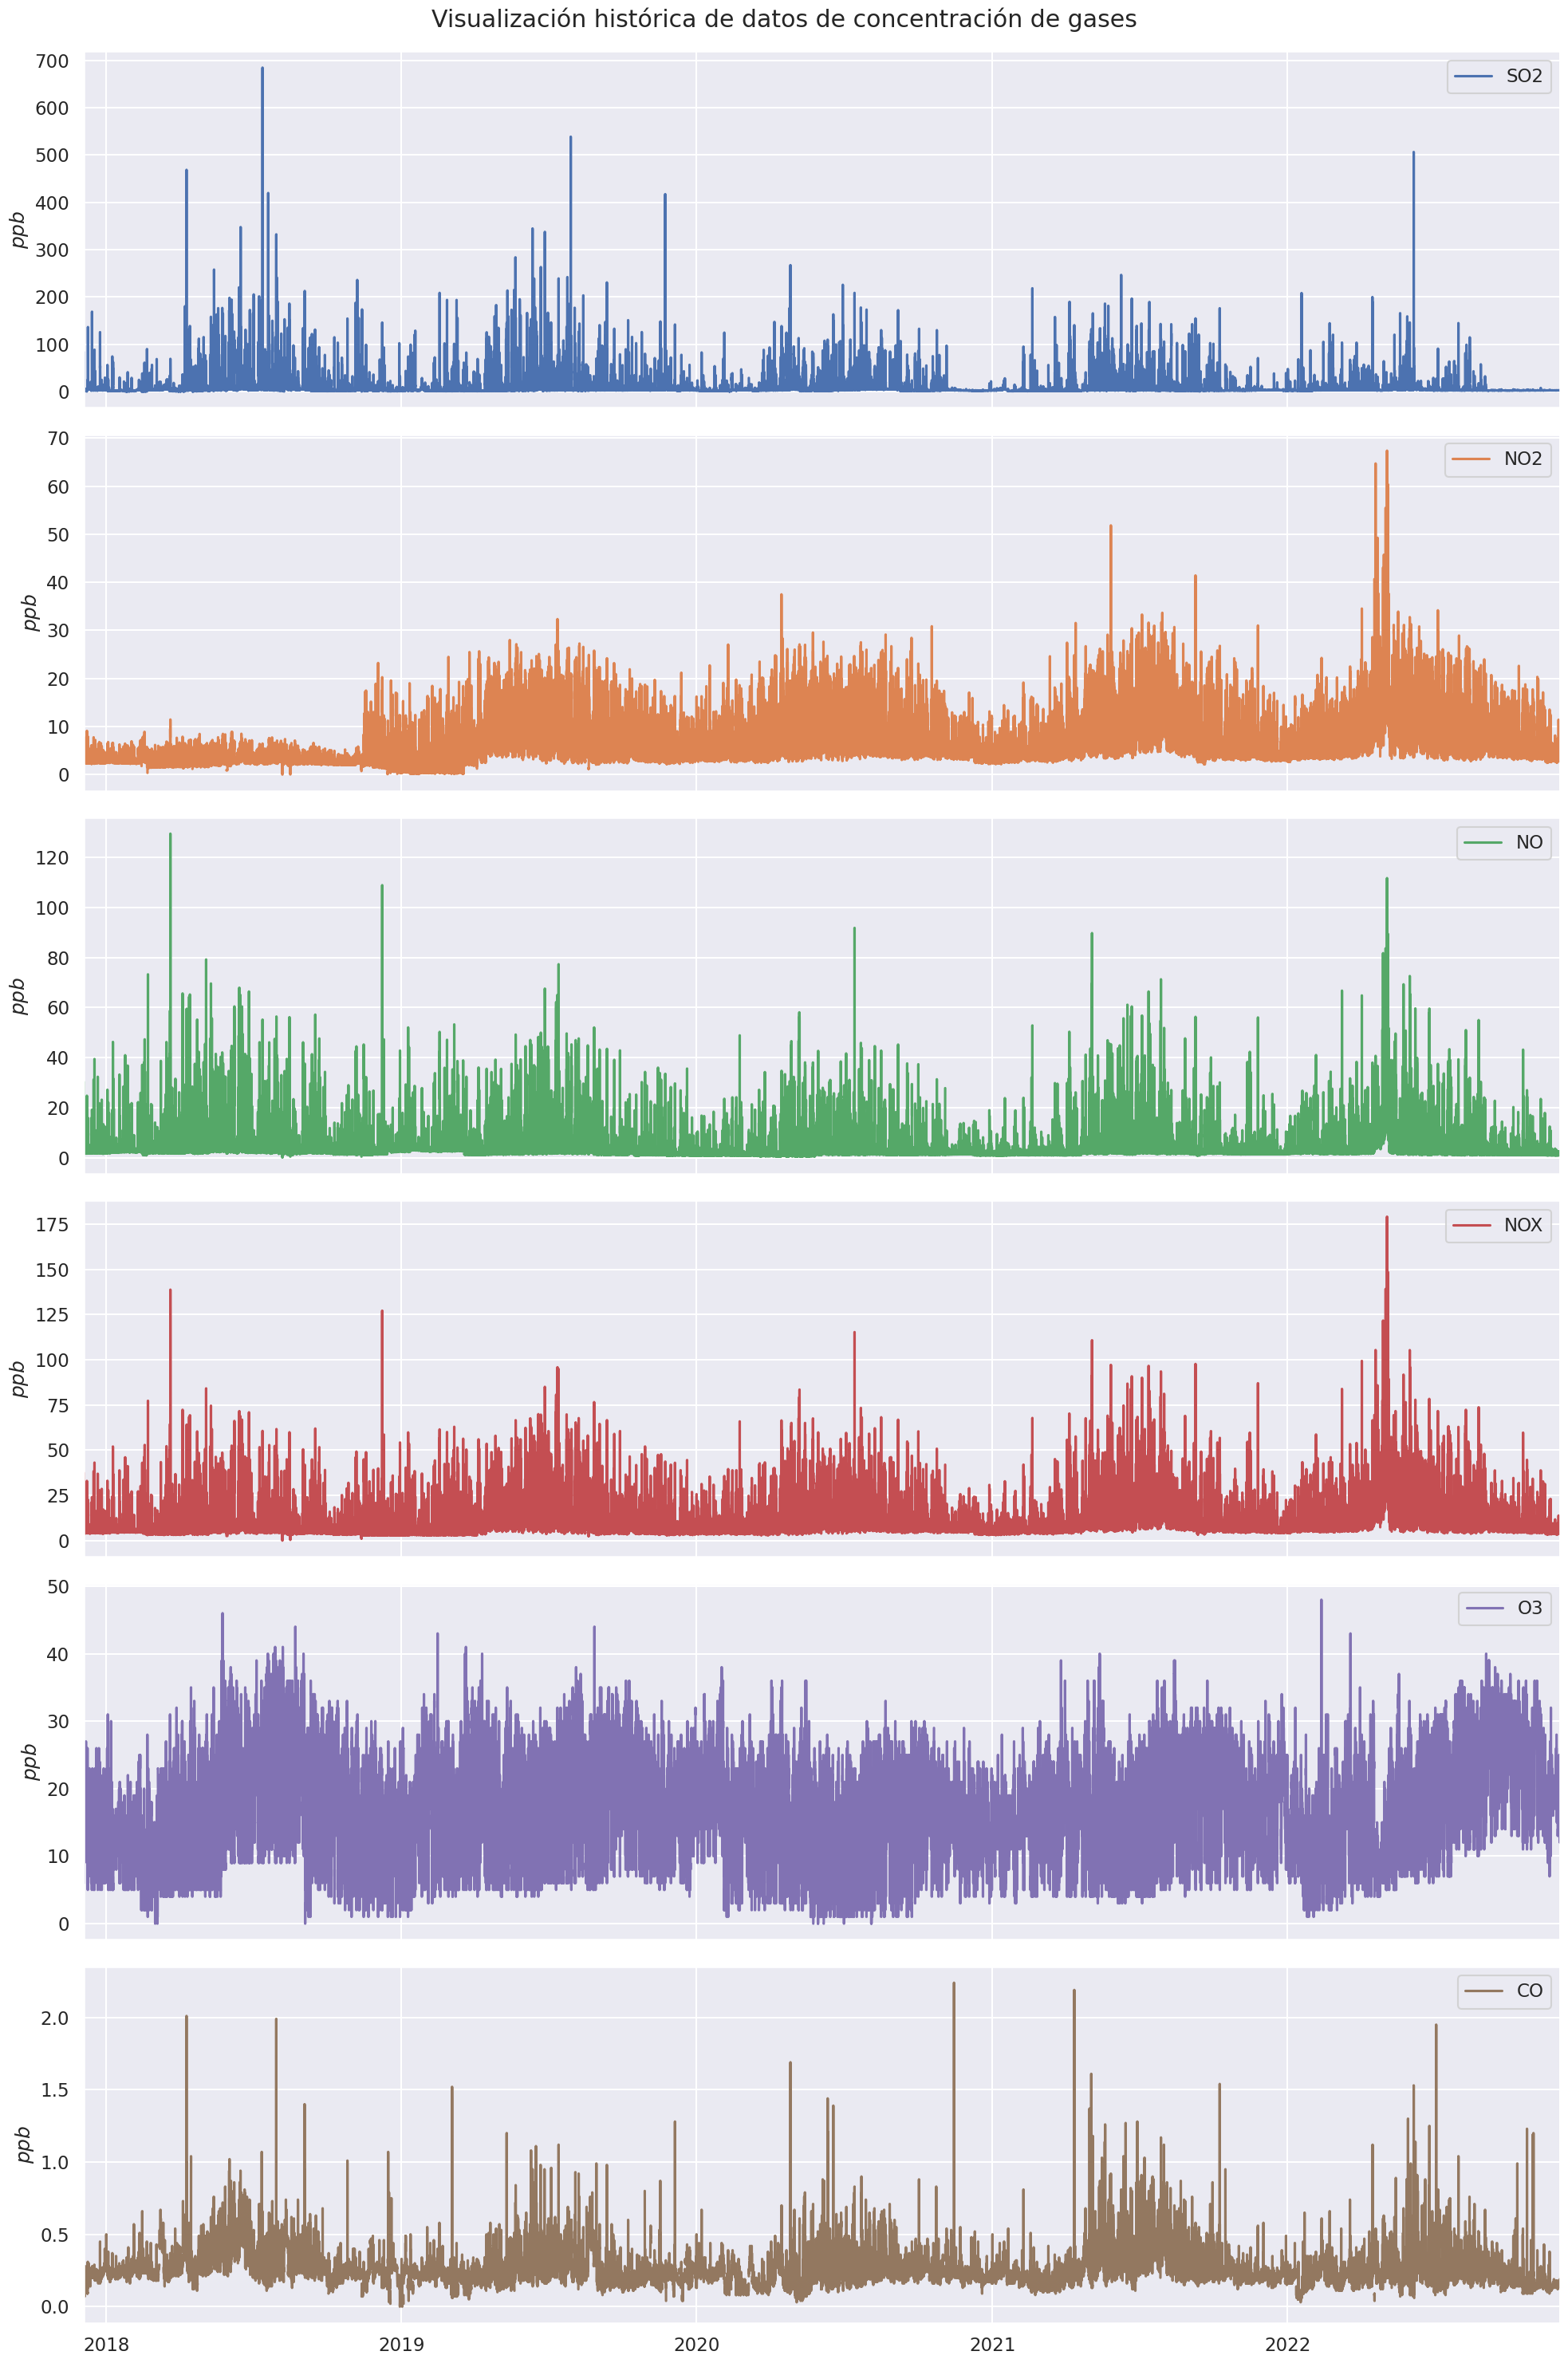

In [11]:
data_df.plot(figsize=(20,30), subplots=True, ylabel=r'$ppb$')
plt.suptitle('Visualización histórica de datos de concentración de gases', y=0.99)
plt.tight_layout()
plt.show()

## Estadísticas

### Histogramas

/home/agonzalez/projects/mds7201-minma-so2/src/eda/visualization.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


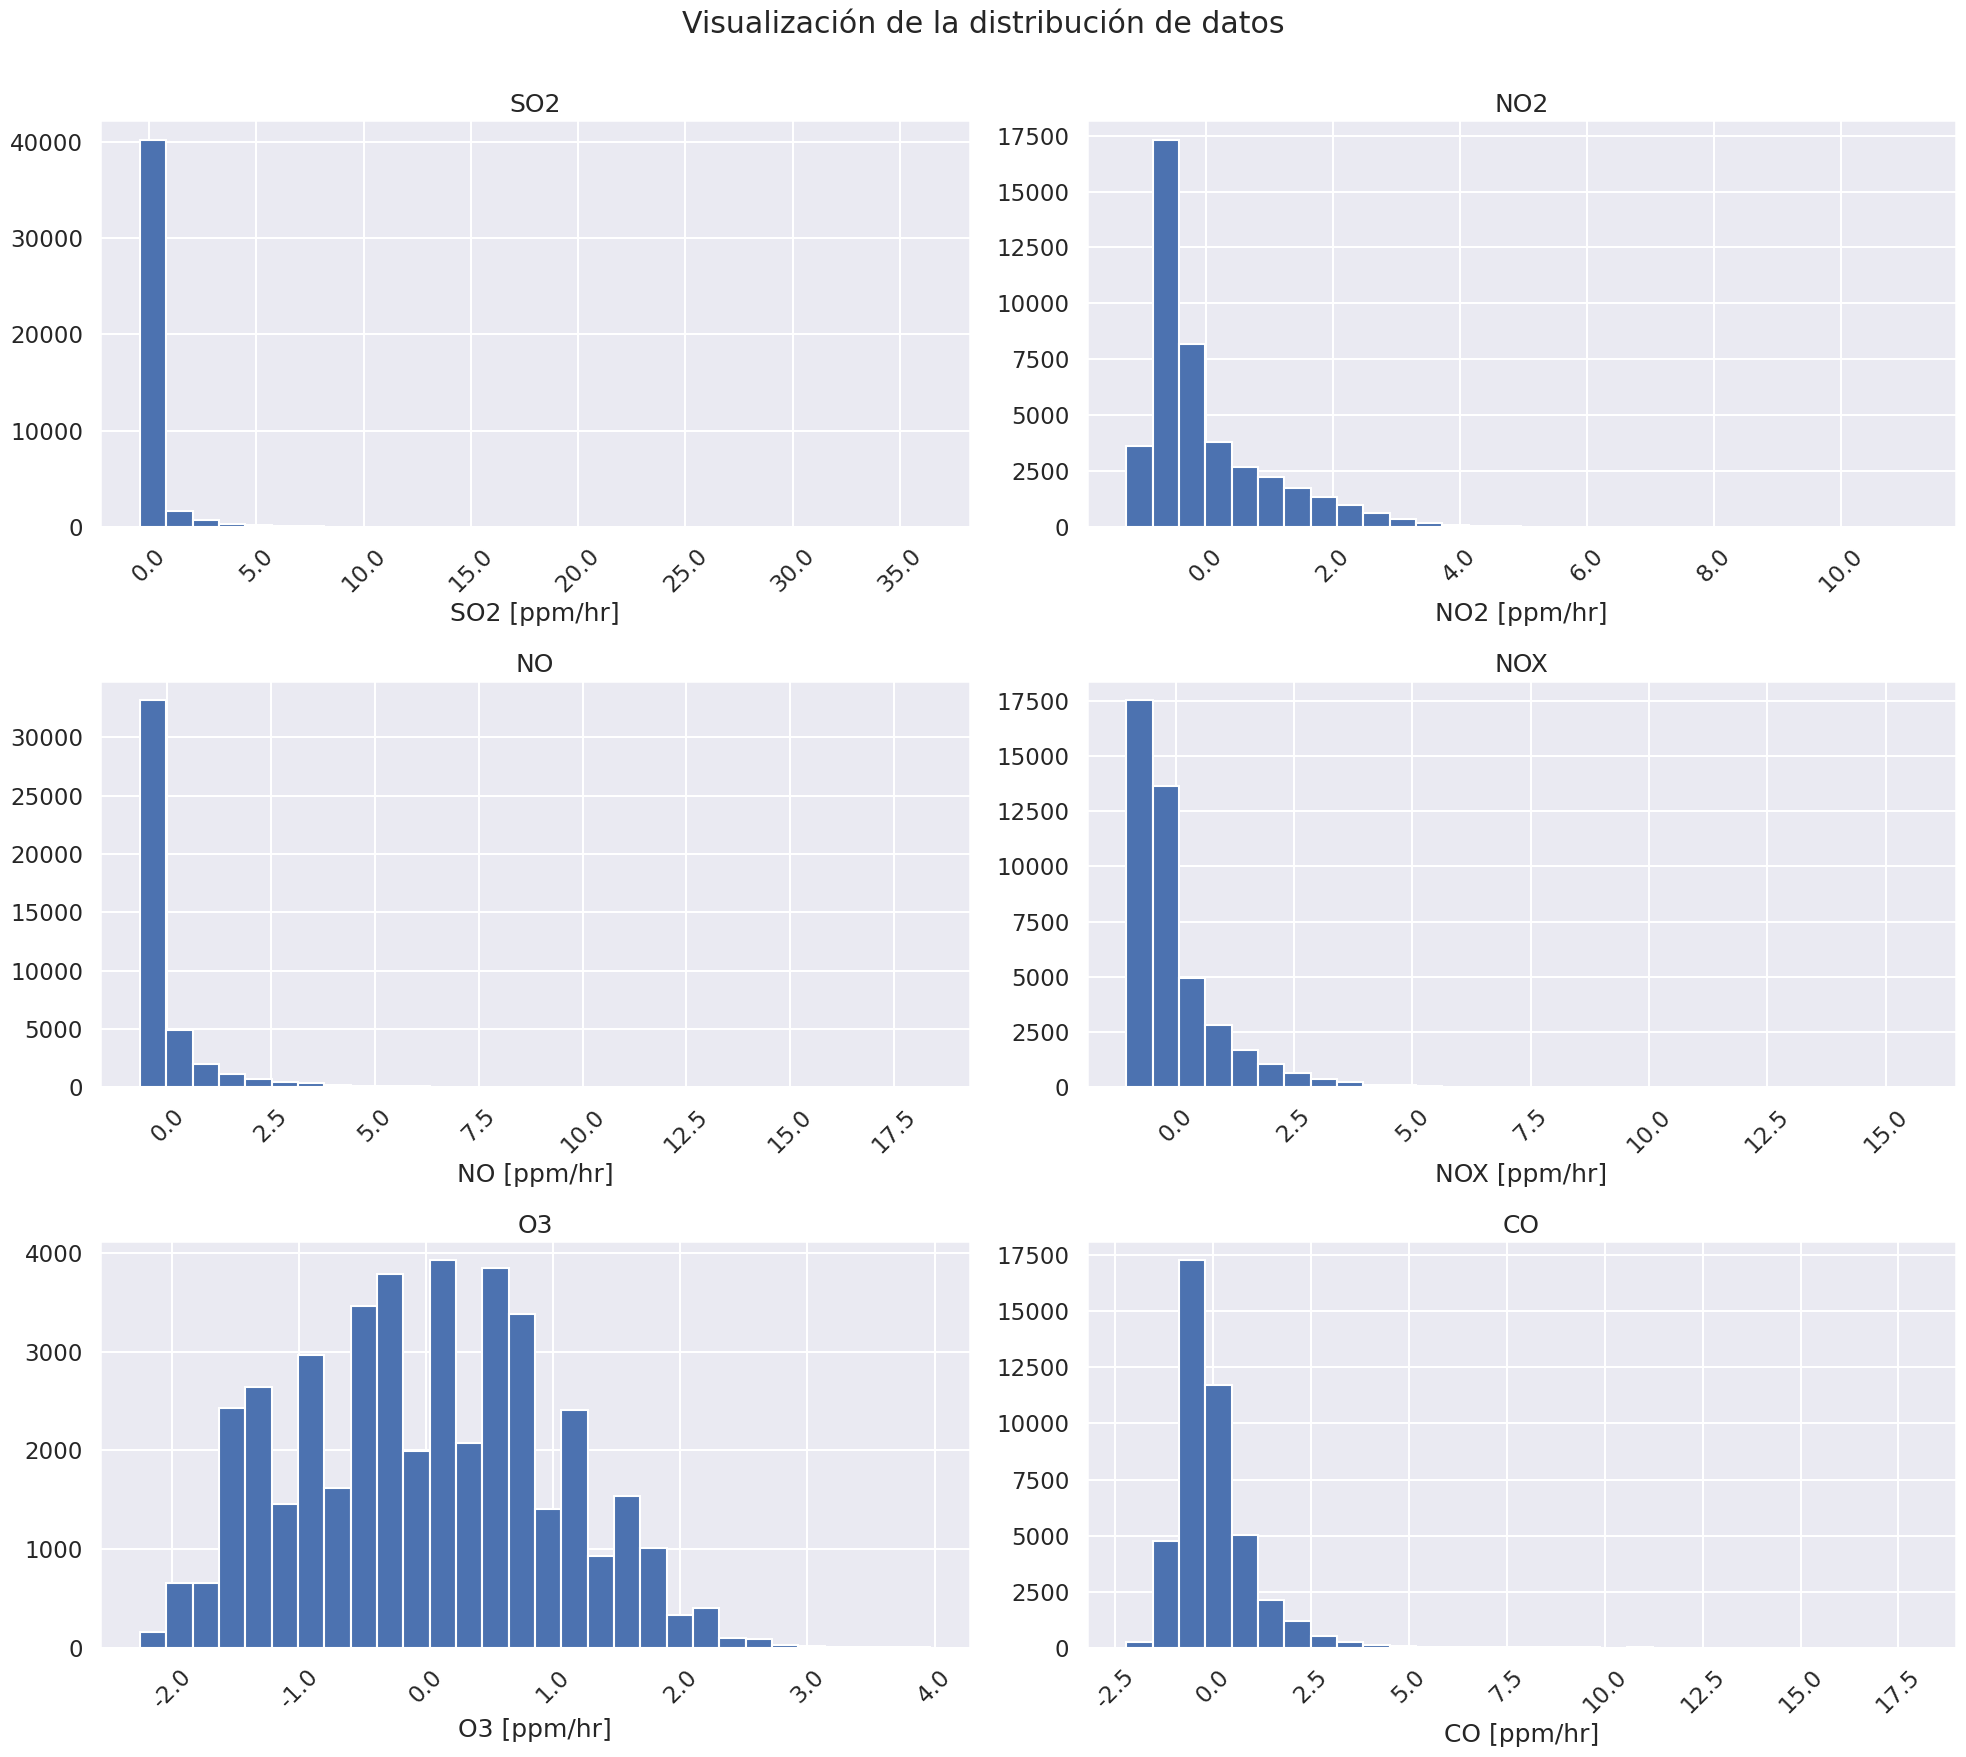

In [12]:
args = {'xscale':'log', 'yscale':'log'} # -> Descomentar para aplica escala logaritmica
xlabel_list = [str(a) + b for a,b in zip(data_df.columns.tolist(),[' [ppm/hr]']*data_df.shape[1])]
data_df_norm = (data_df - data_df.mean()) / data_df.std()
hist_plot(data_df_norm, xlabel_list=xlabel_list) #, **args) -> Opcional para escala logaritmica, u otros parámetros

- SO2, NO, NOX y NO2 con un comportamiento 'más estable' a valores pequeños, indicando de que no existen peaks todos los días (lo que sería fatal).

### Resumen estadístico

In [13]:
data_df.describe()

SO2           NO2            NO           NOX            O3  \
count  43365.000000  43267.000000  43320.000000  43320.000000  43302.000000   
mean       7.901357      6.752581      4.493766     11.162724     17.384278   
std       18.592834      5.417808      6.807502     10.734627      7.722470   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.190000      3.230000      1.507653      4.943848     11.000000   
50%        2.890000      4.620000      2.183640      6.906240     17.000000   
75%        5.020000      8.655000      4.017512     13.134075     23.000000   
max      684.630000     67.380000    129.551000    179.154000     48.000000   

                 CO  
count  43323.000000  
mean       0.245222  
std        0.111059  
min        0.000000  
25%        0.180000  
50%        0.220000  
75%        0.280000  
max        2.240000

## Correlaciones entre datos

### Pair plot

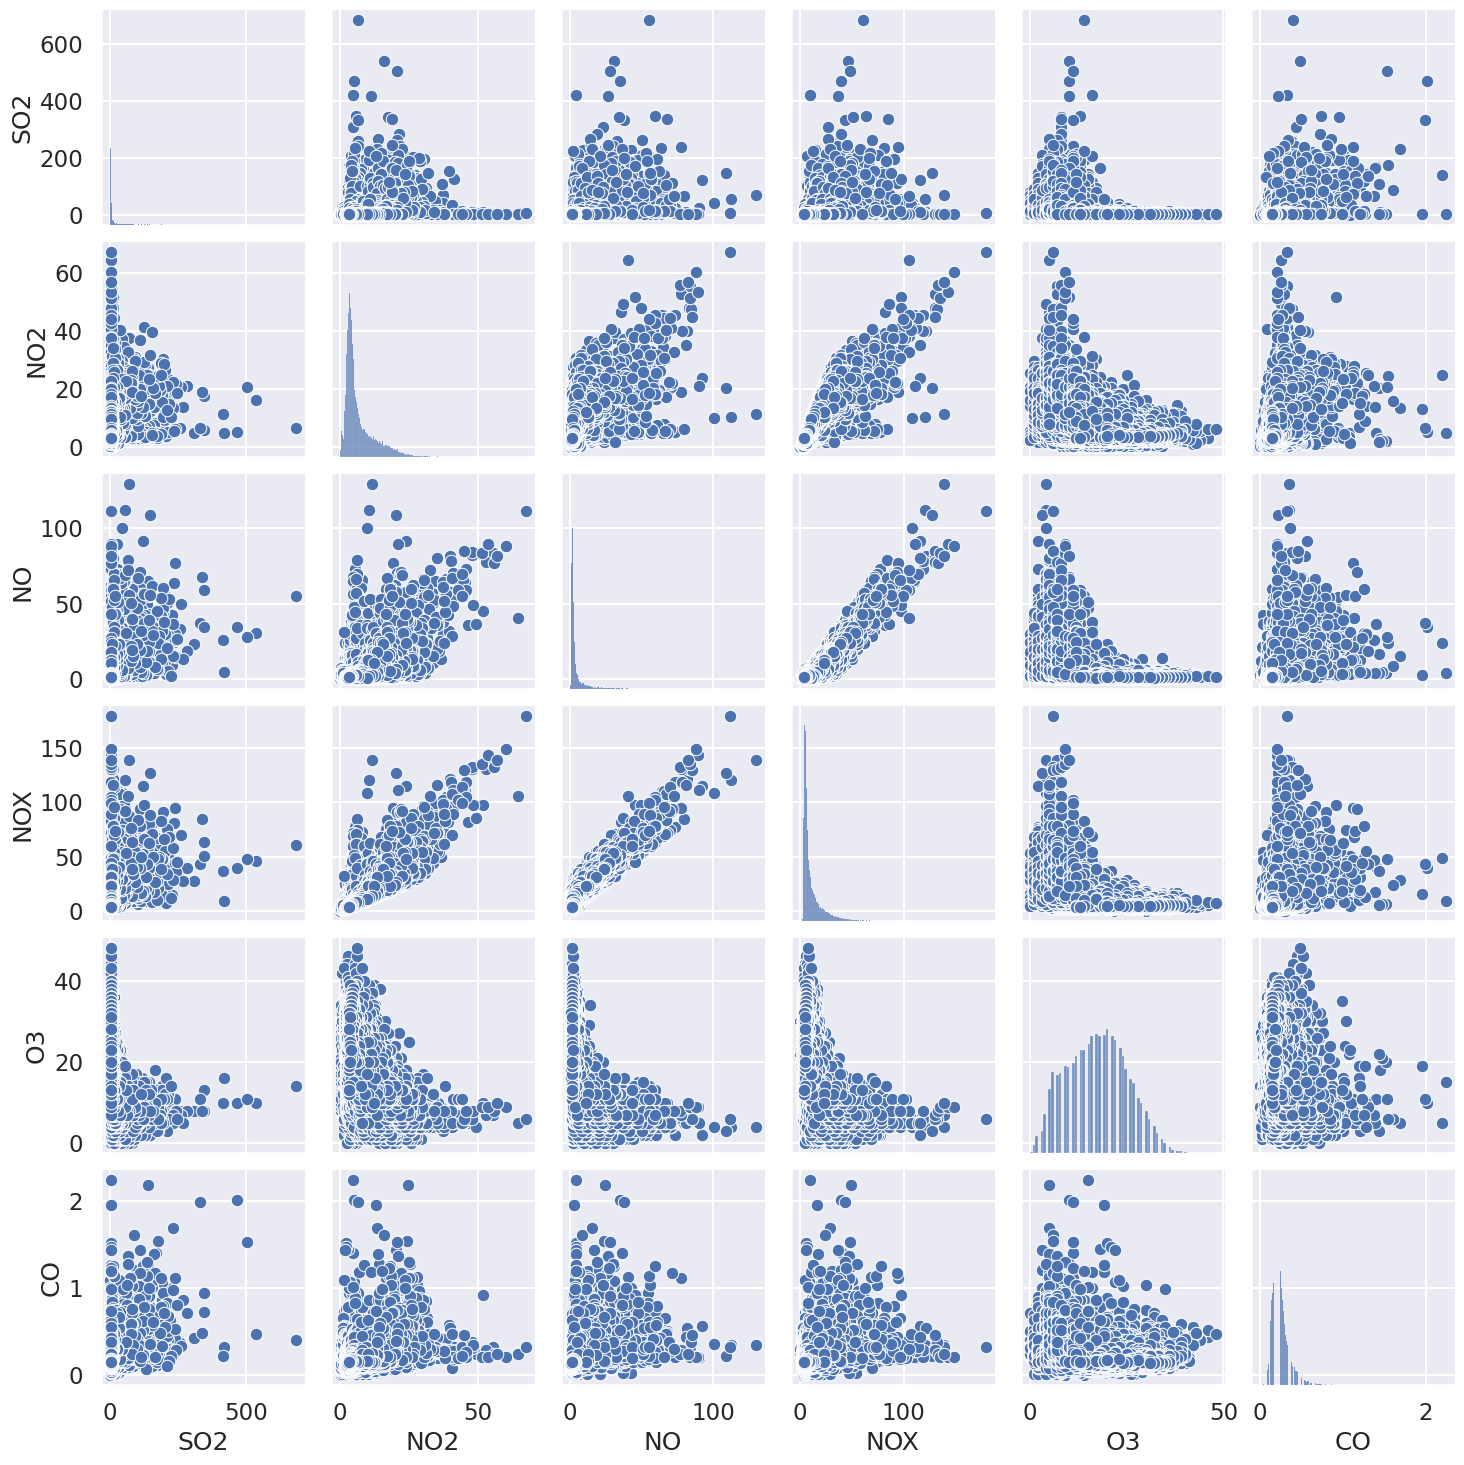

In [14]:
sns.pairplot(data_df)
plt.show()

- Alta correlación entre NO y NOX
- Correlación entre NO2 y NOX
- Correlación entre NO2, NO, NOX y SO"

### Matriz de confusion

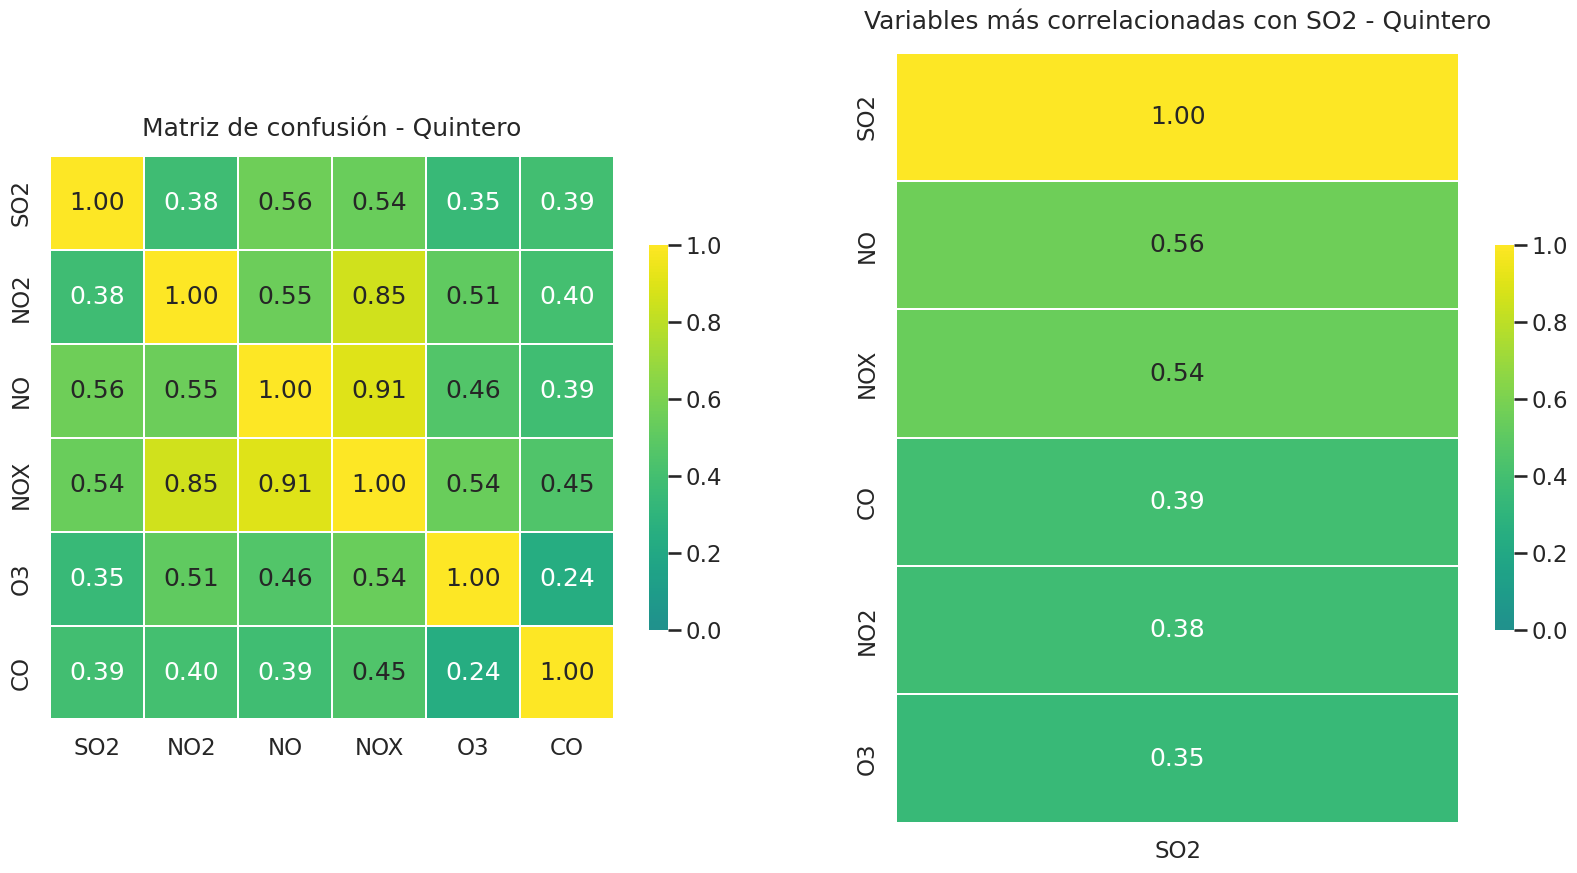

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

conf_matrix(data_df, ax=ax[0])
ax[0].set_title('Matriz de confusión - Quintero', y=1.02)

conf_matrix(data_df, SO2_only=True, ax=ax[1])
ax[1].set_title('Variables más correlacionadas con SO2 - Quintero', y=1.02)
plt.show()

## Lag plots

### 1 hora

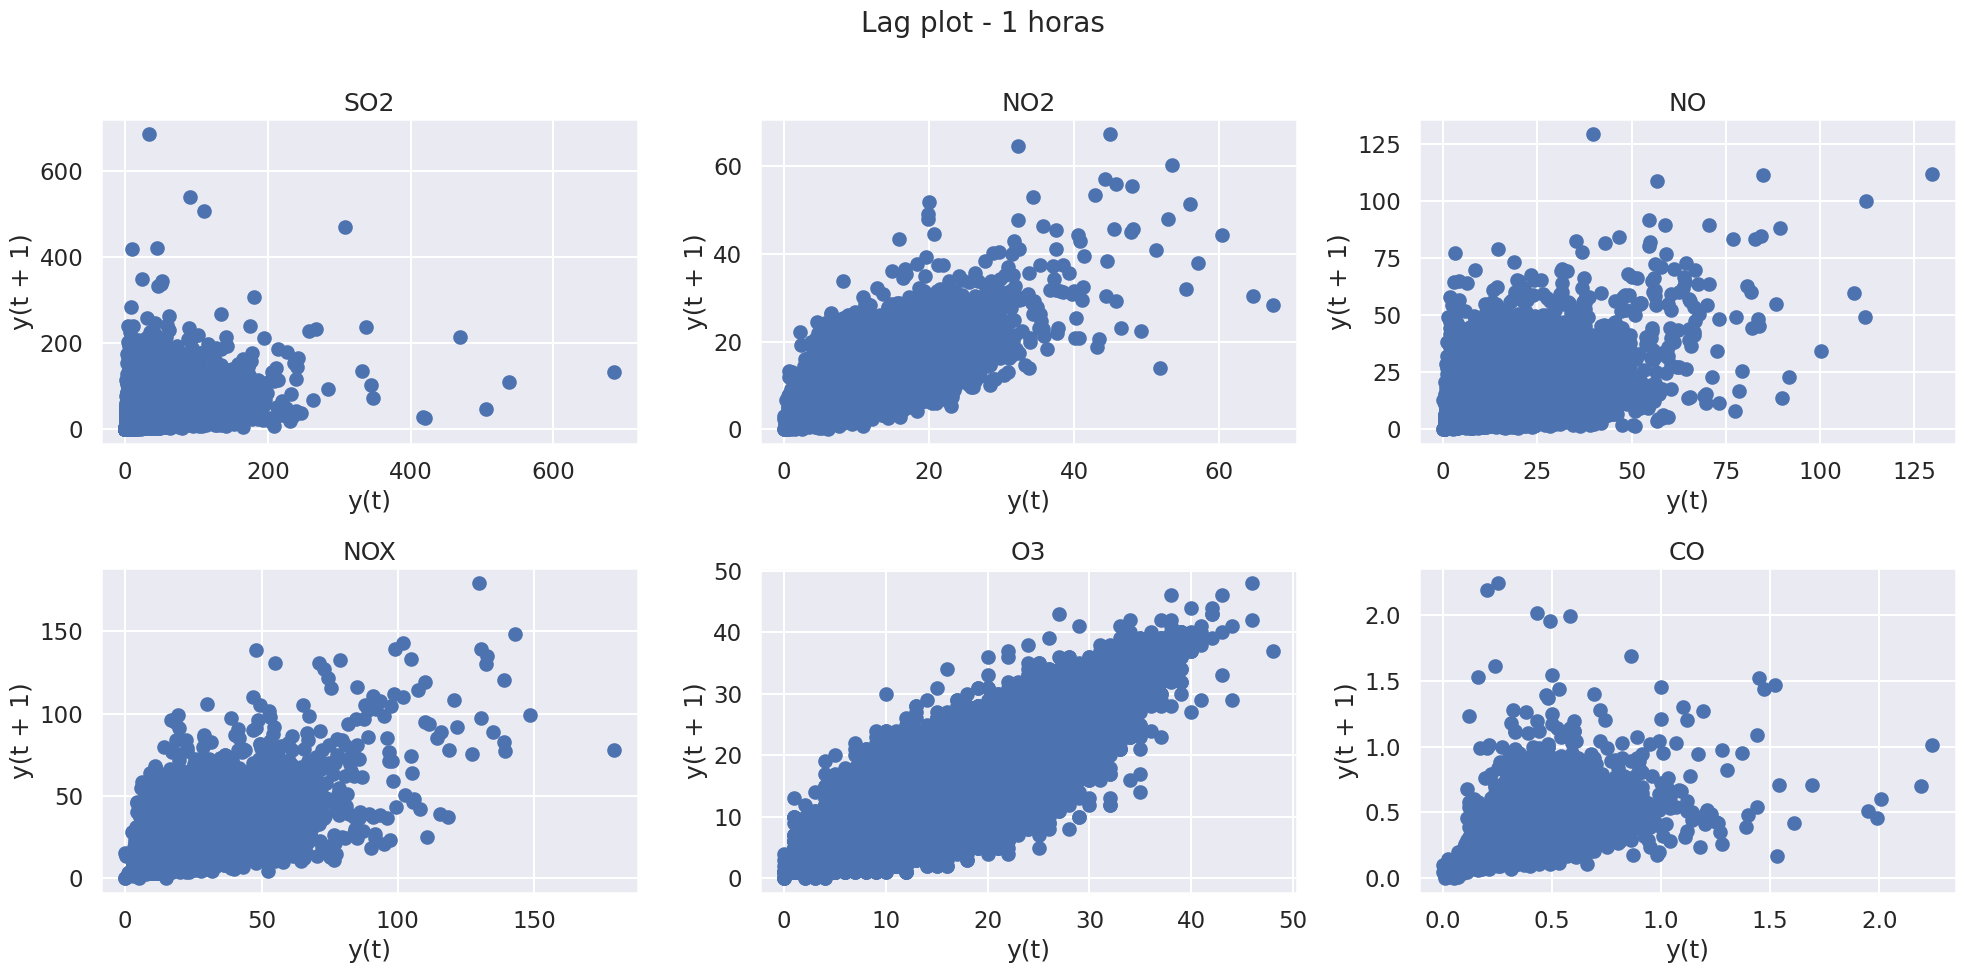

In [16]:
lag_plot(data_df, lag=1, unit='horas')

### 1 día

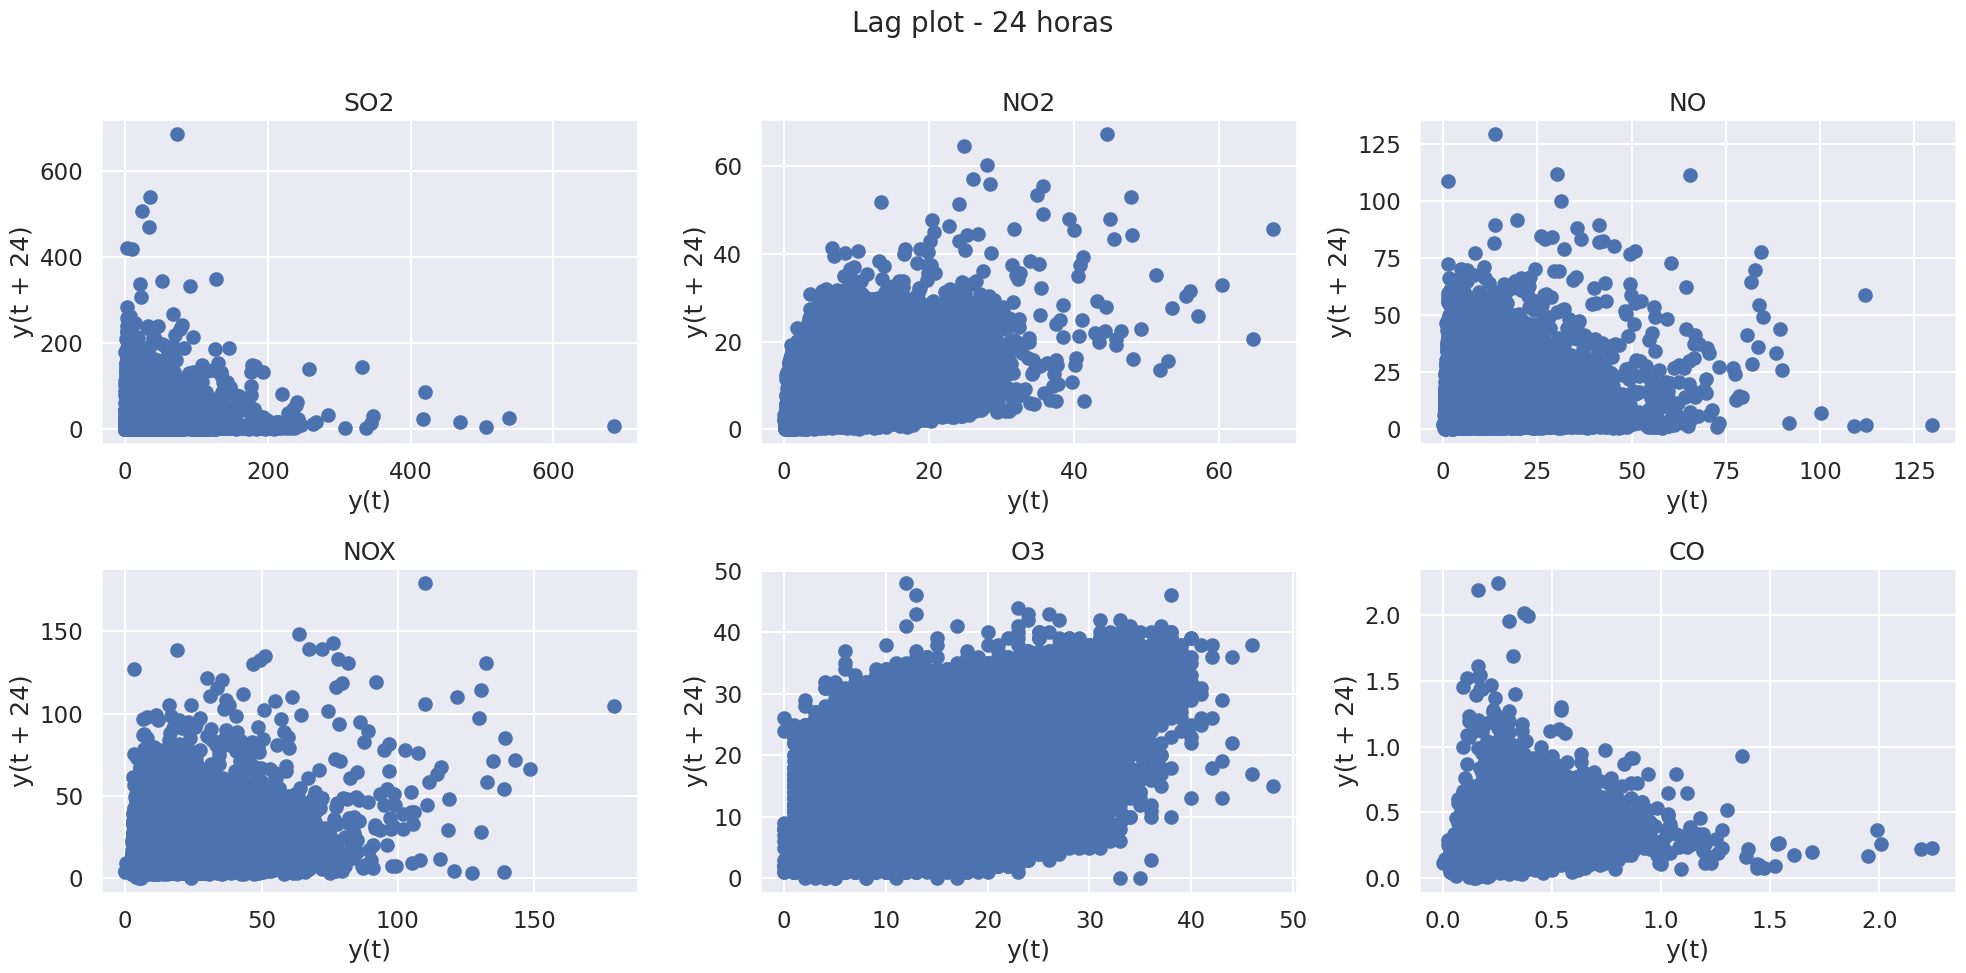

In [17]:
lag_plot(data_df, lag=24, unit='horas')

## Tendencias

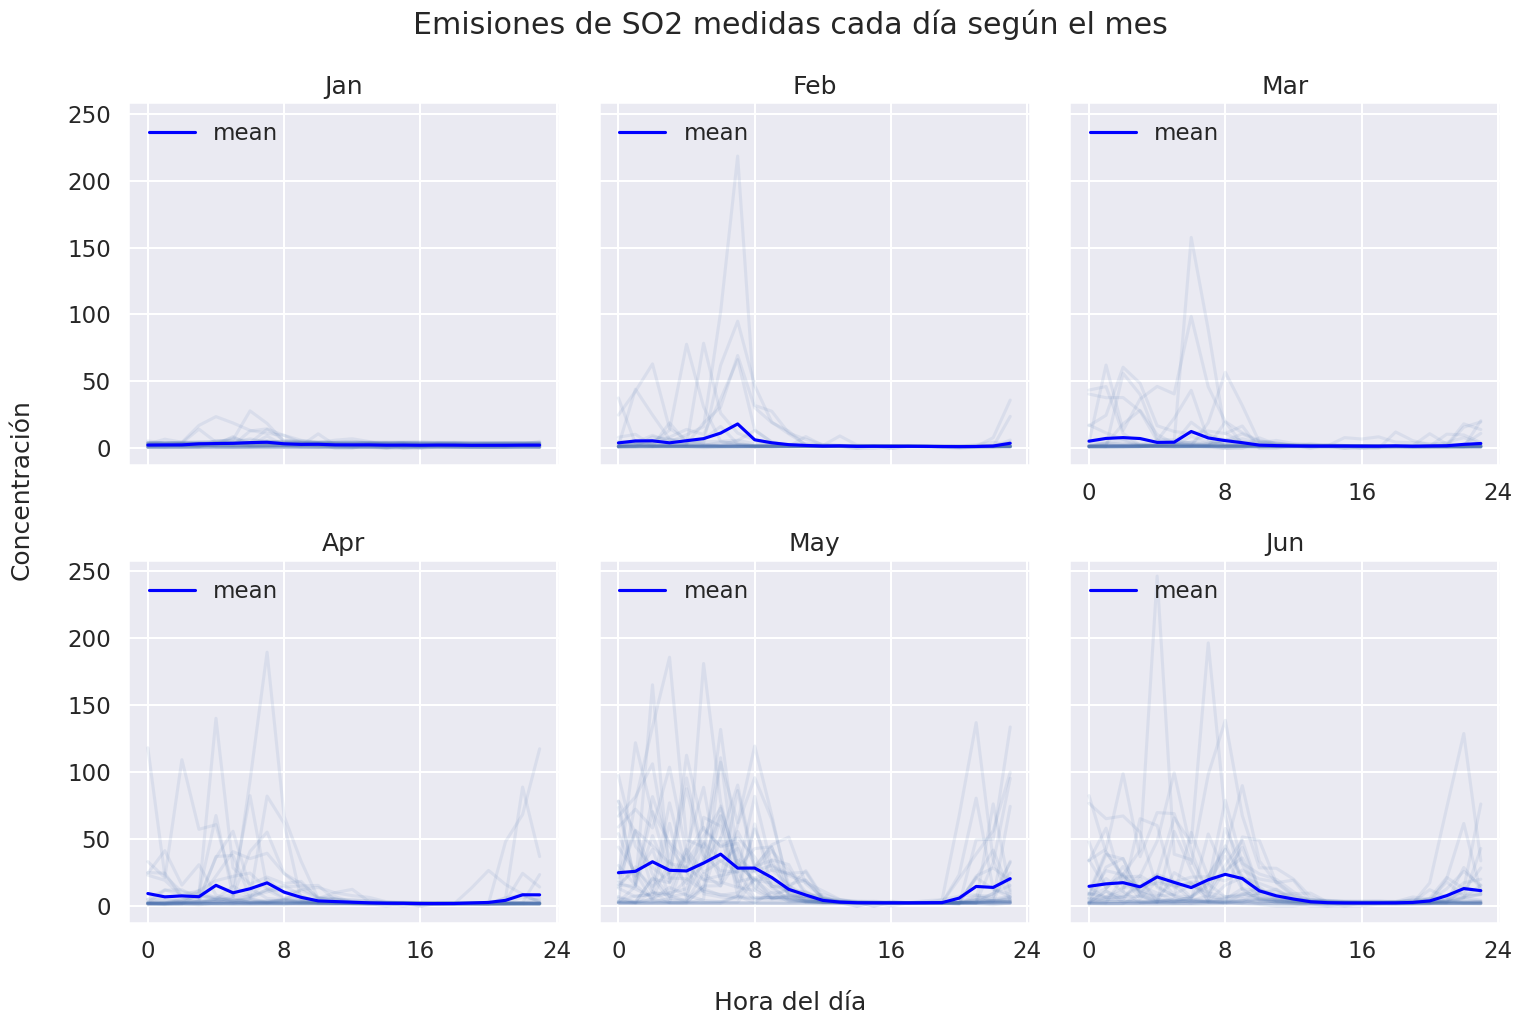

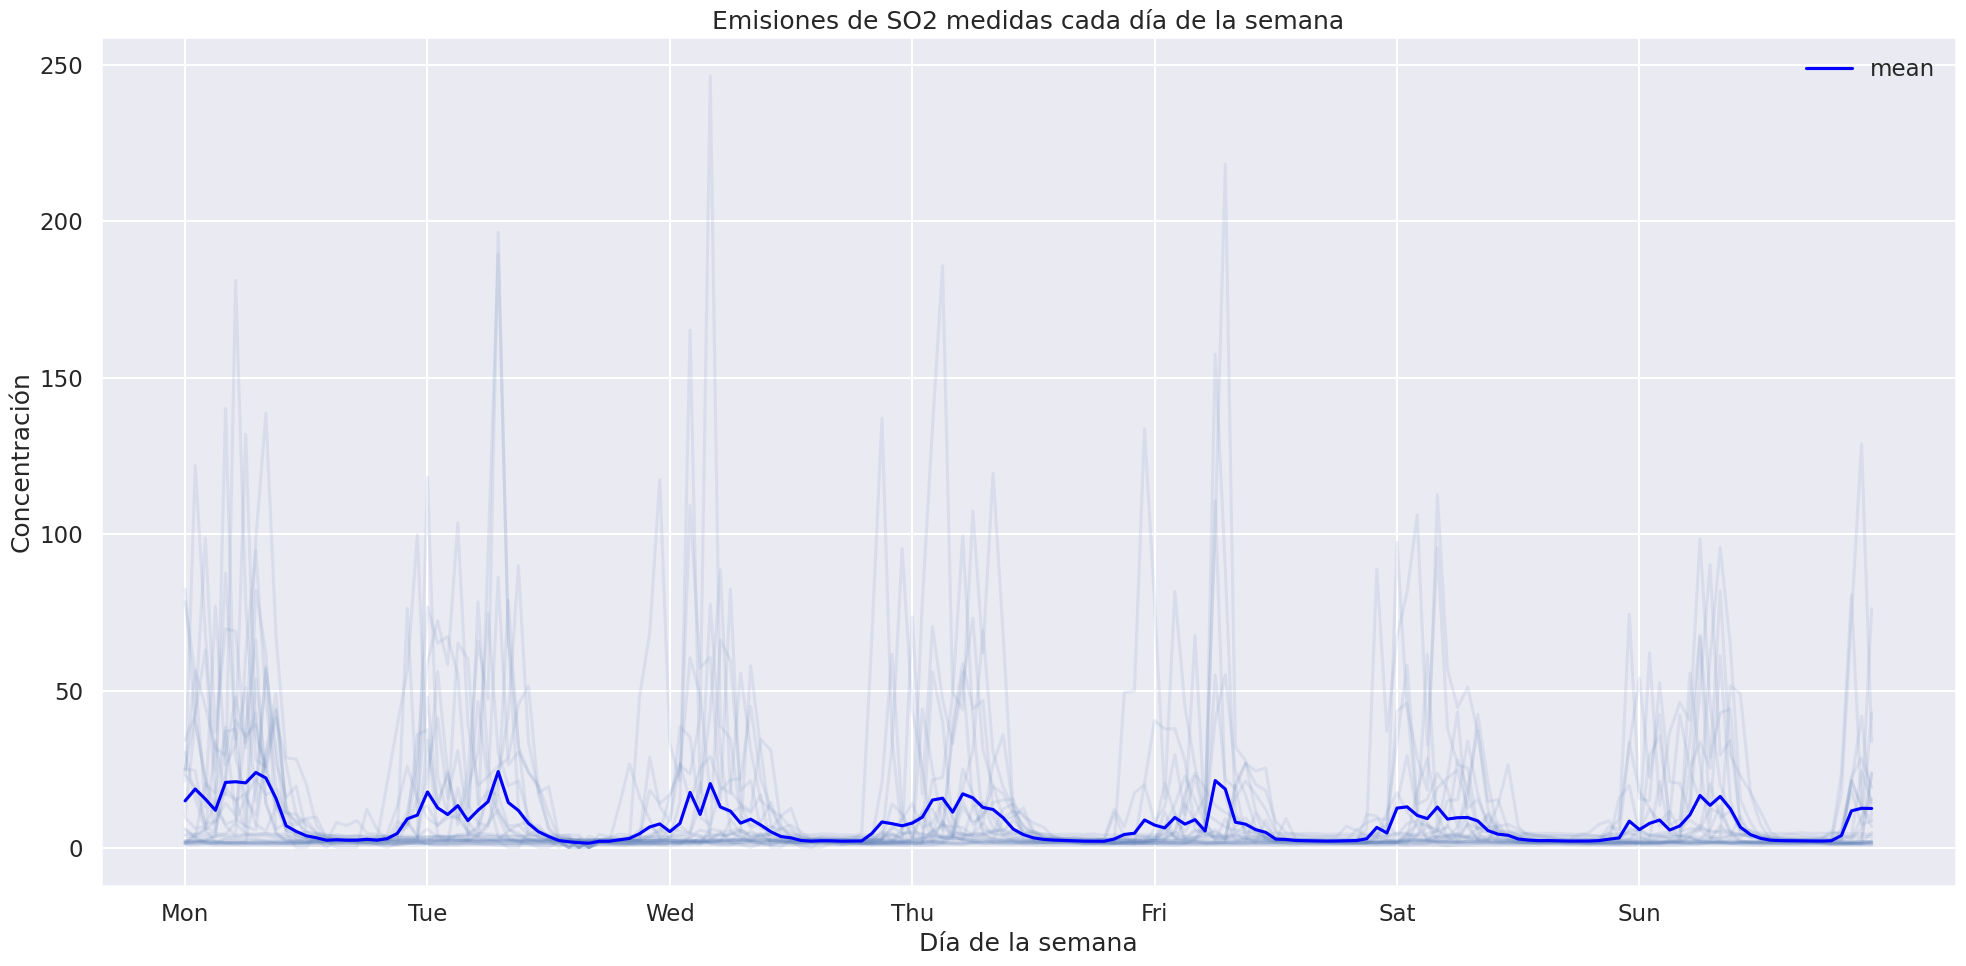

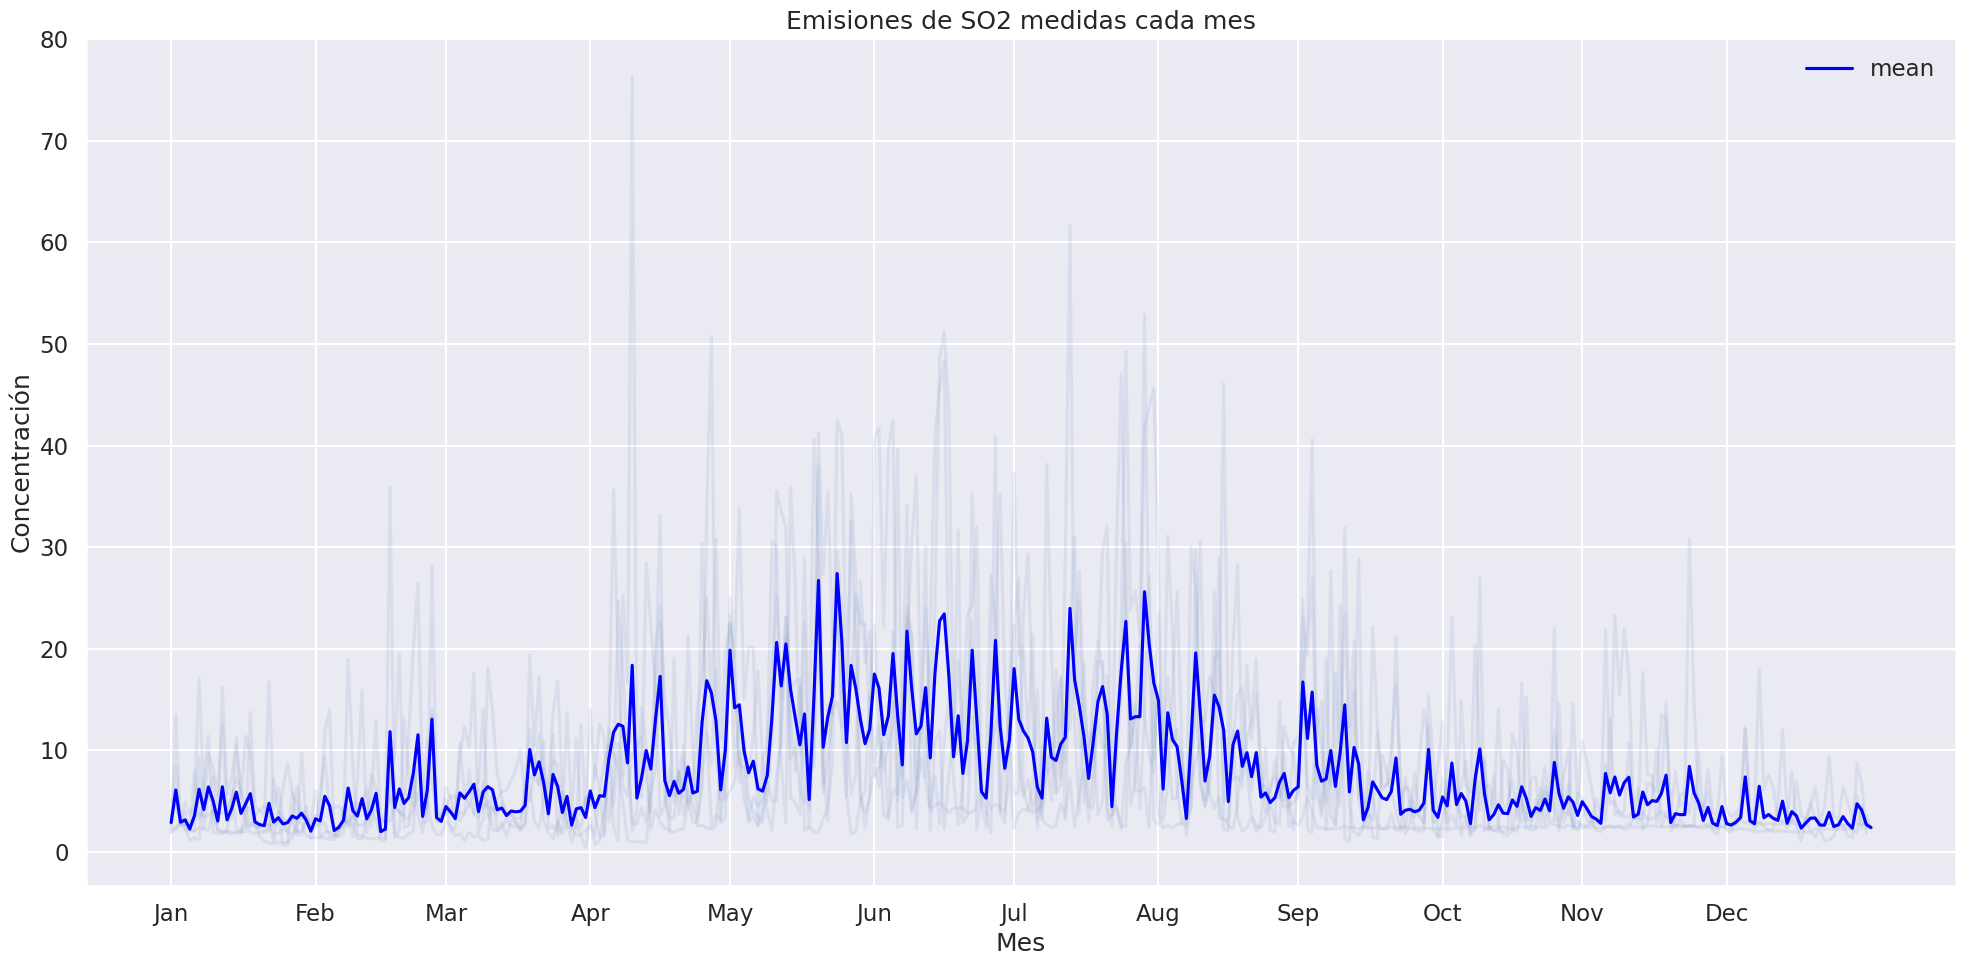

In [18]:
visualizar_trends(data_df, col = "SO2", ano_0=2021, title='Emisiones de SO2')

## Análisis de peaks

In [19]:
# Separación de días normales y peaks
_, peak_days = get_SO2_peaks(data_df, 'SO2', 130)
_, limit_days = get_SO2_limit(data_df, 'SO2', 130)

# Filtro de dataframe según el tipo de día
data_peaks_df = filter_by_dates(data_df, peak_days)
data_limit50_df = filter_by_dates(data_df, limit_days)

# Indices de fechas, a horas
# data_hourly_peaks_df = dates_to_hours(data_peaks_df)
# data_hourly_limit50_df = dates_to_hours(data_limit50_df)

### Conteo de peaks por semana y estación del año

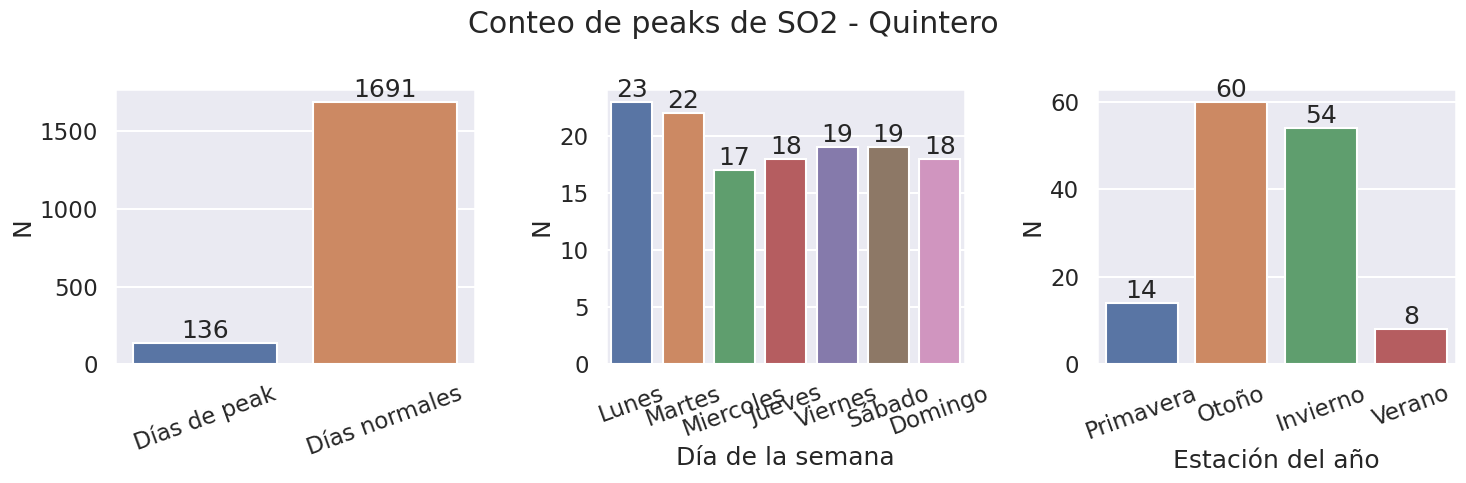

In [20]:
plot_peak_counts(data_peaks_df, data_limit50_df, 'Quintero')

### Distribución acumulada de distintas métricas

/home/agonzalez/projects/mds7201-minma-so2/src/eda/visualization.py:213: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


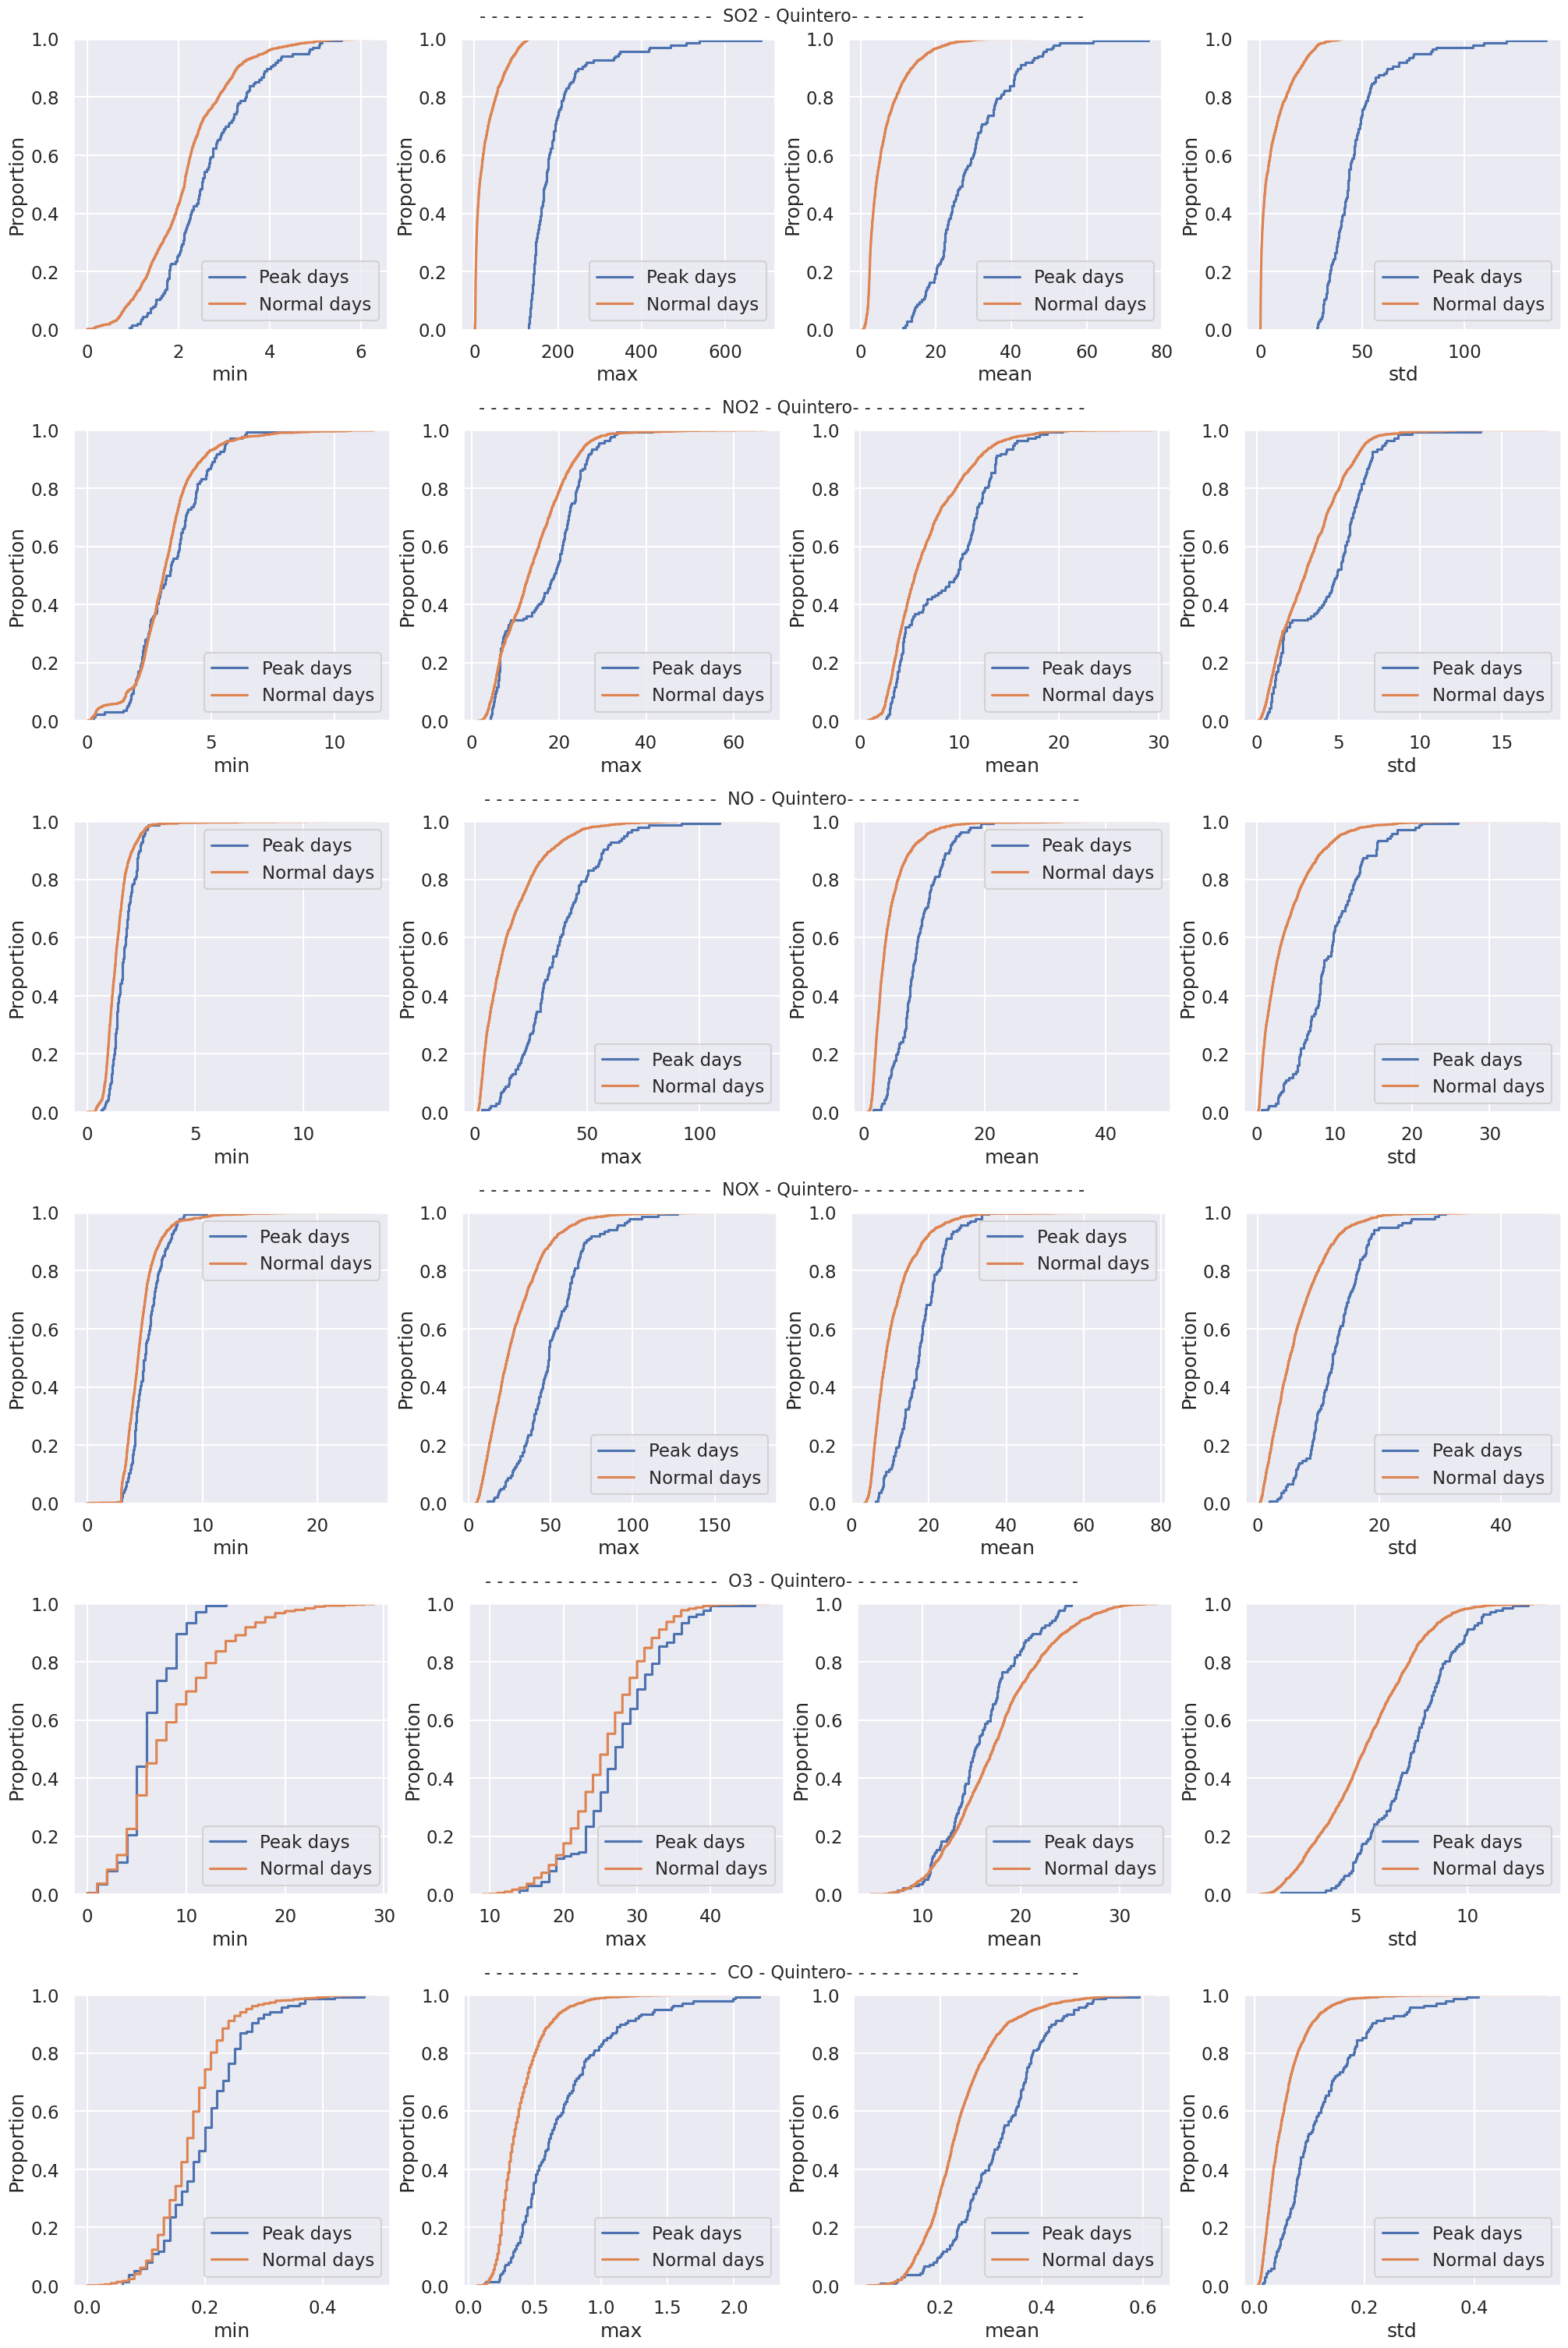

In [22]:
plot_temp([data_peaks_df, data_limit50_df], 'Quintero', type='cumdistr')

### Comparación de distribución acumulada entre distintas variables

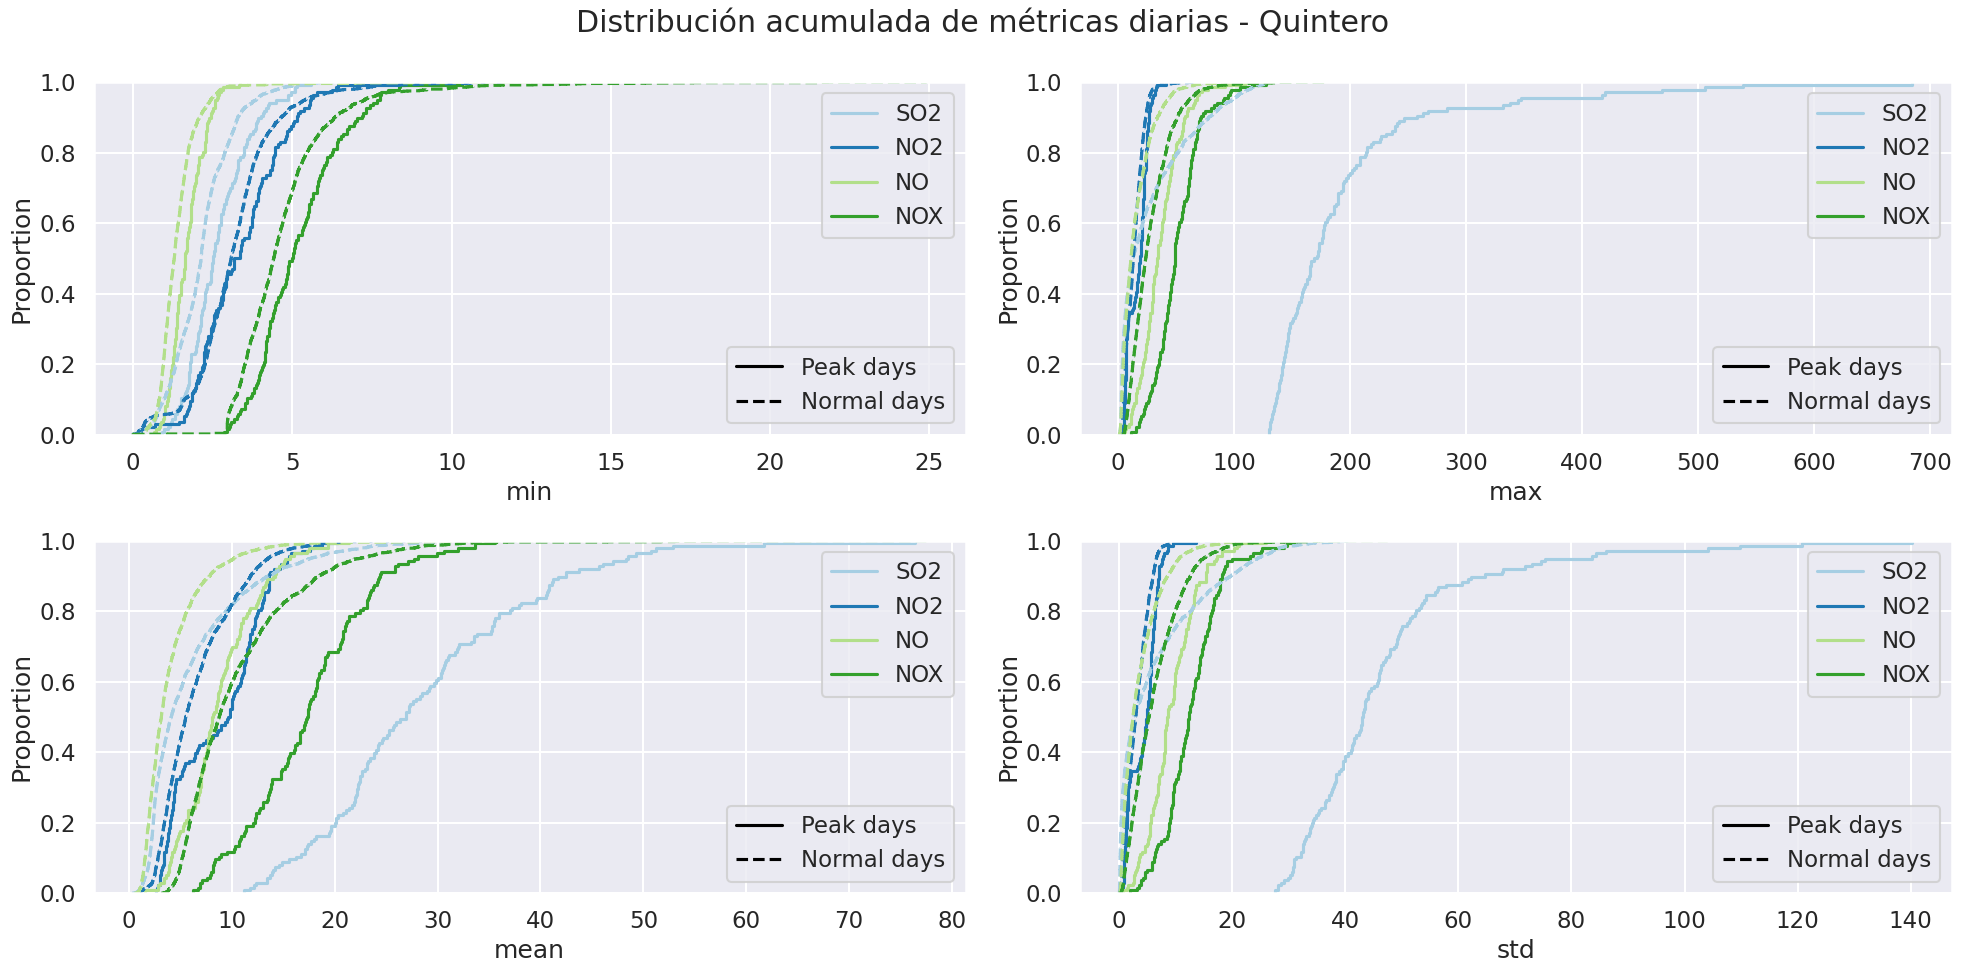

In [23]:
cumdistr_comparison([data_peaks_df, data_limit50_df], 'Quintero', ['SO2', 'NO2', 'NO', 'NOX'], x_log=False)

### Comparación horaria

In [27]:
peaks_df = pd.concat(data_peaks_df, axis=0)
limits50_df = pd.concat(data_limit50_df, axis=0)

peaks_df['hour'] = peaks_df.index.hour
limits50_df['hour'] = limits50_df.index.hour

#### SO2

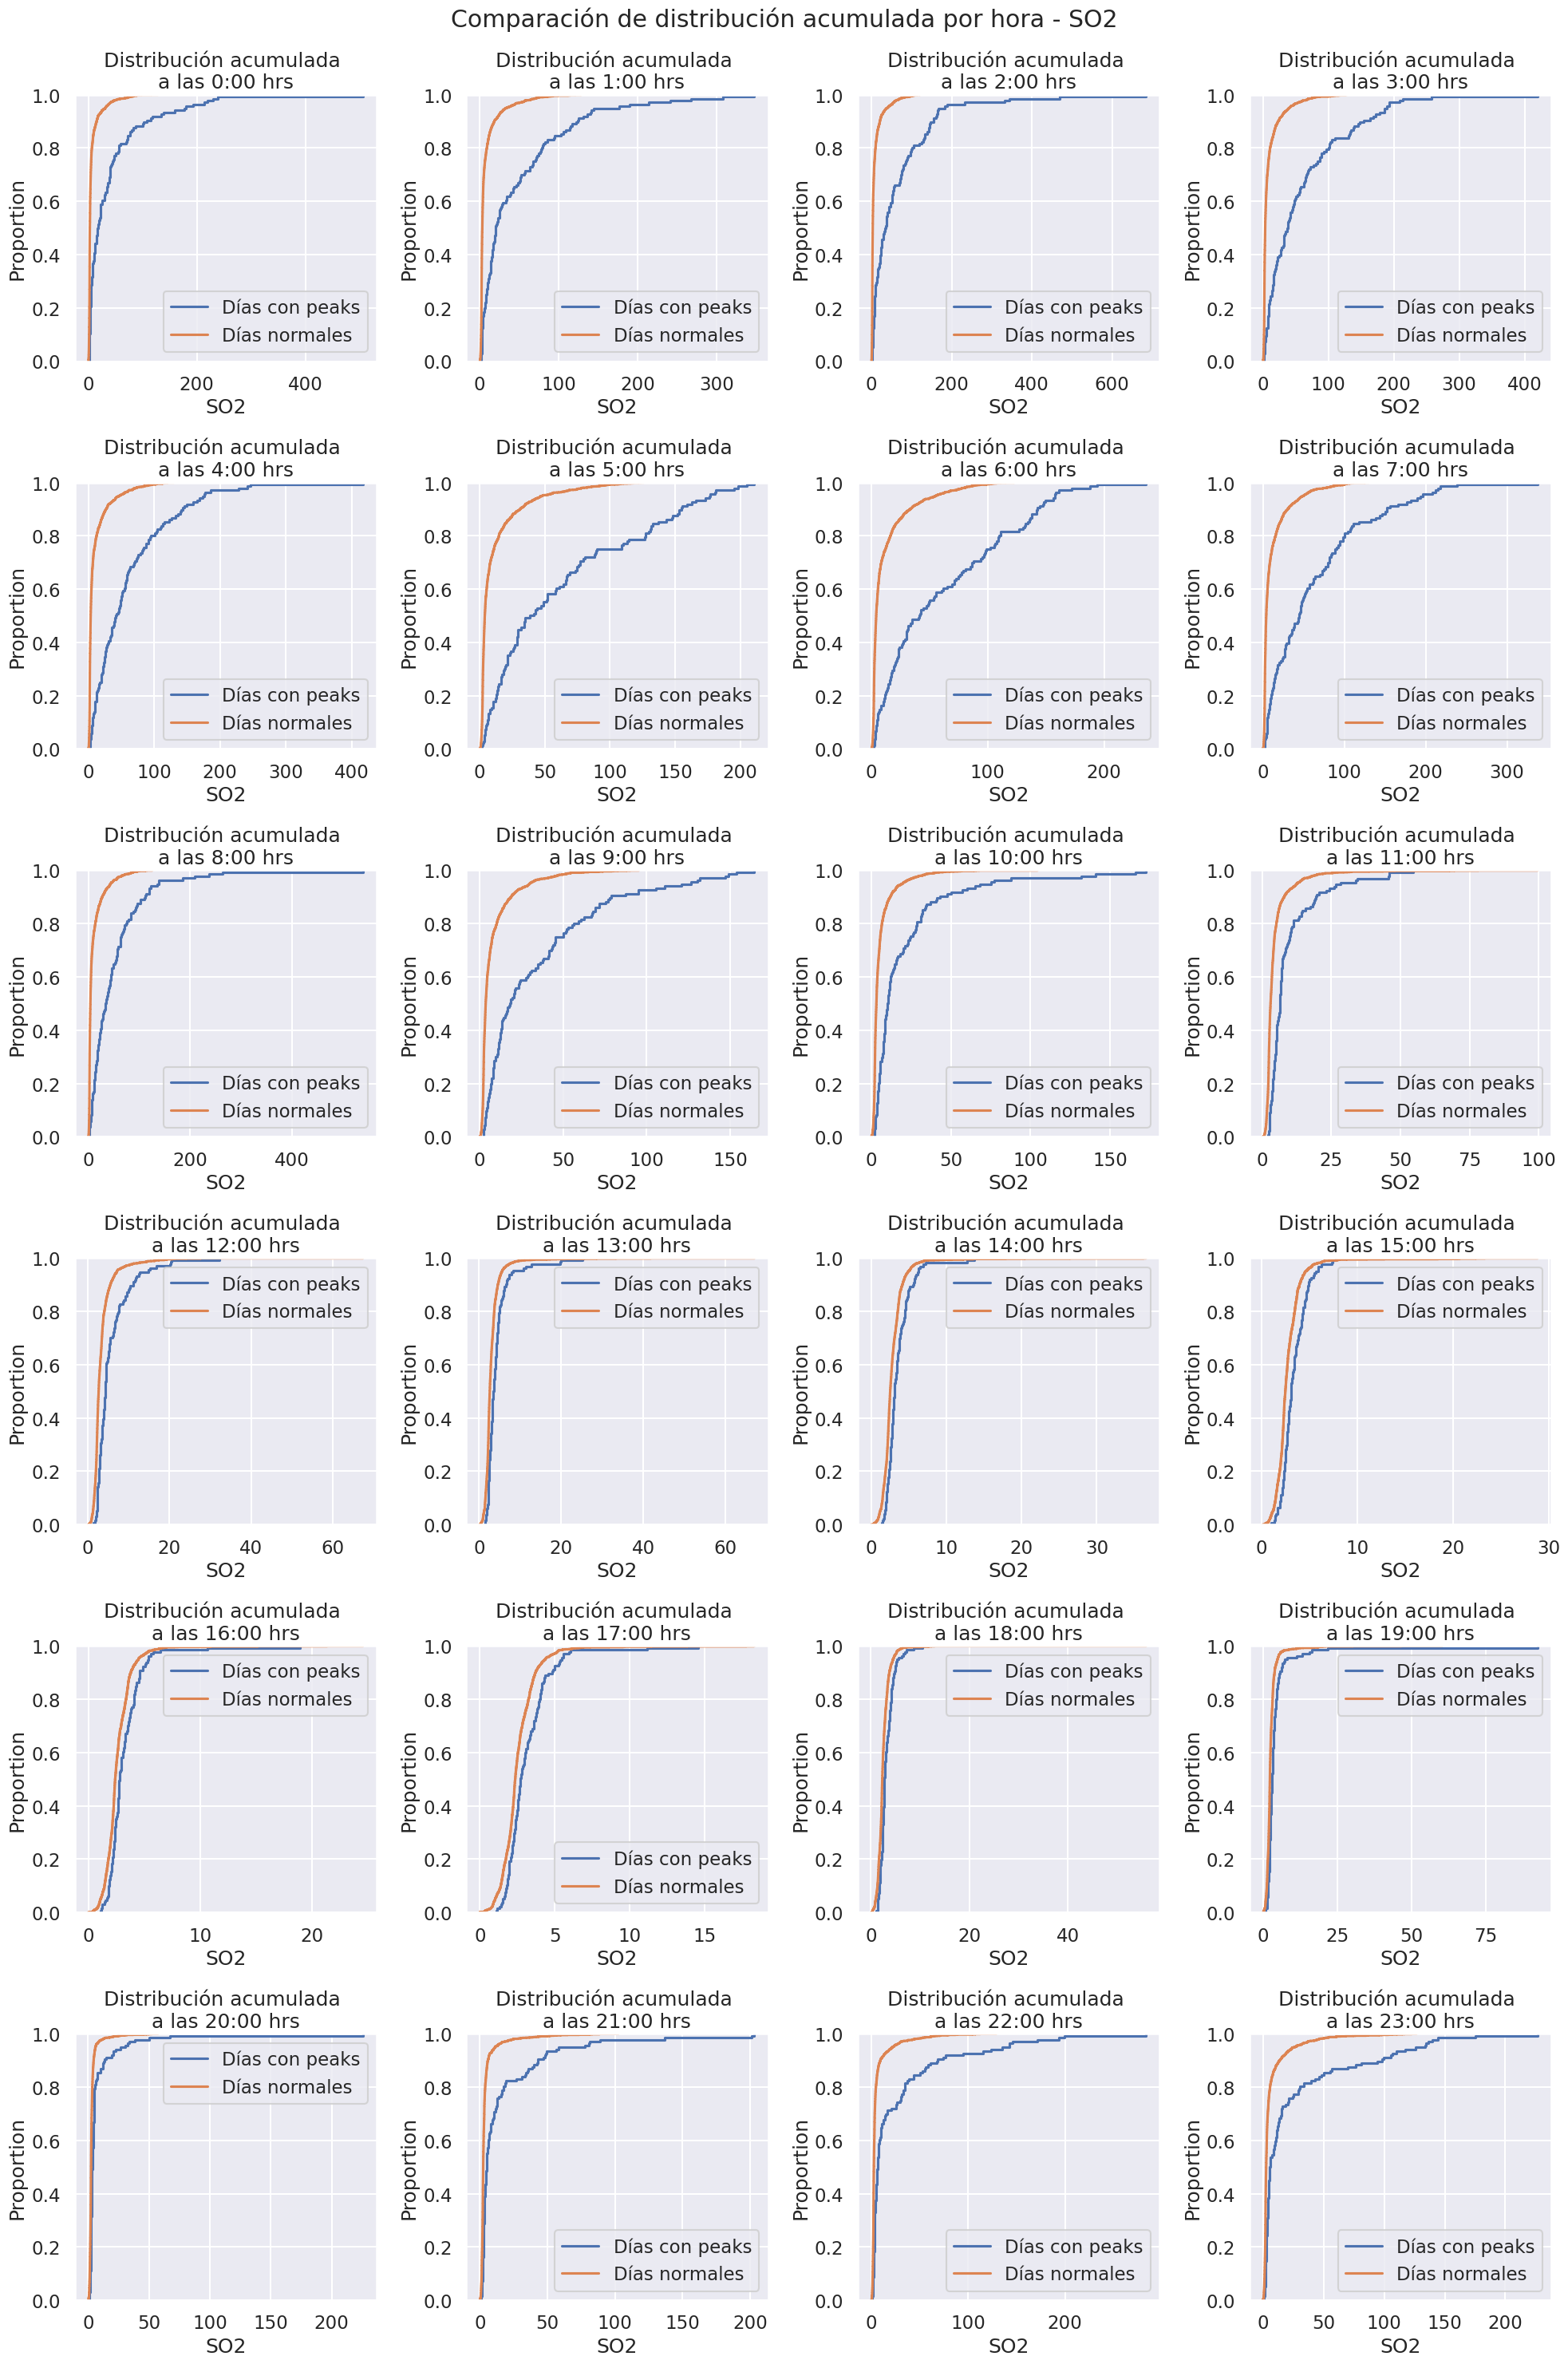

In [29]:
cumdistr_comparacion_horaria(peaks_df, limits50_df, 'Días con peaks', 'Días normales', 'SO2')

#### NO2

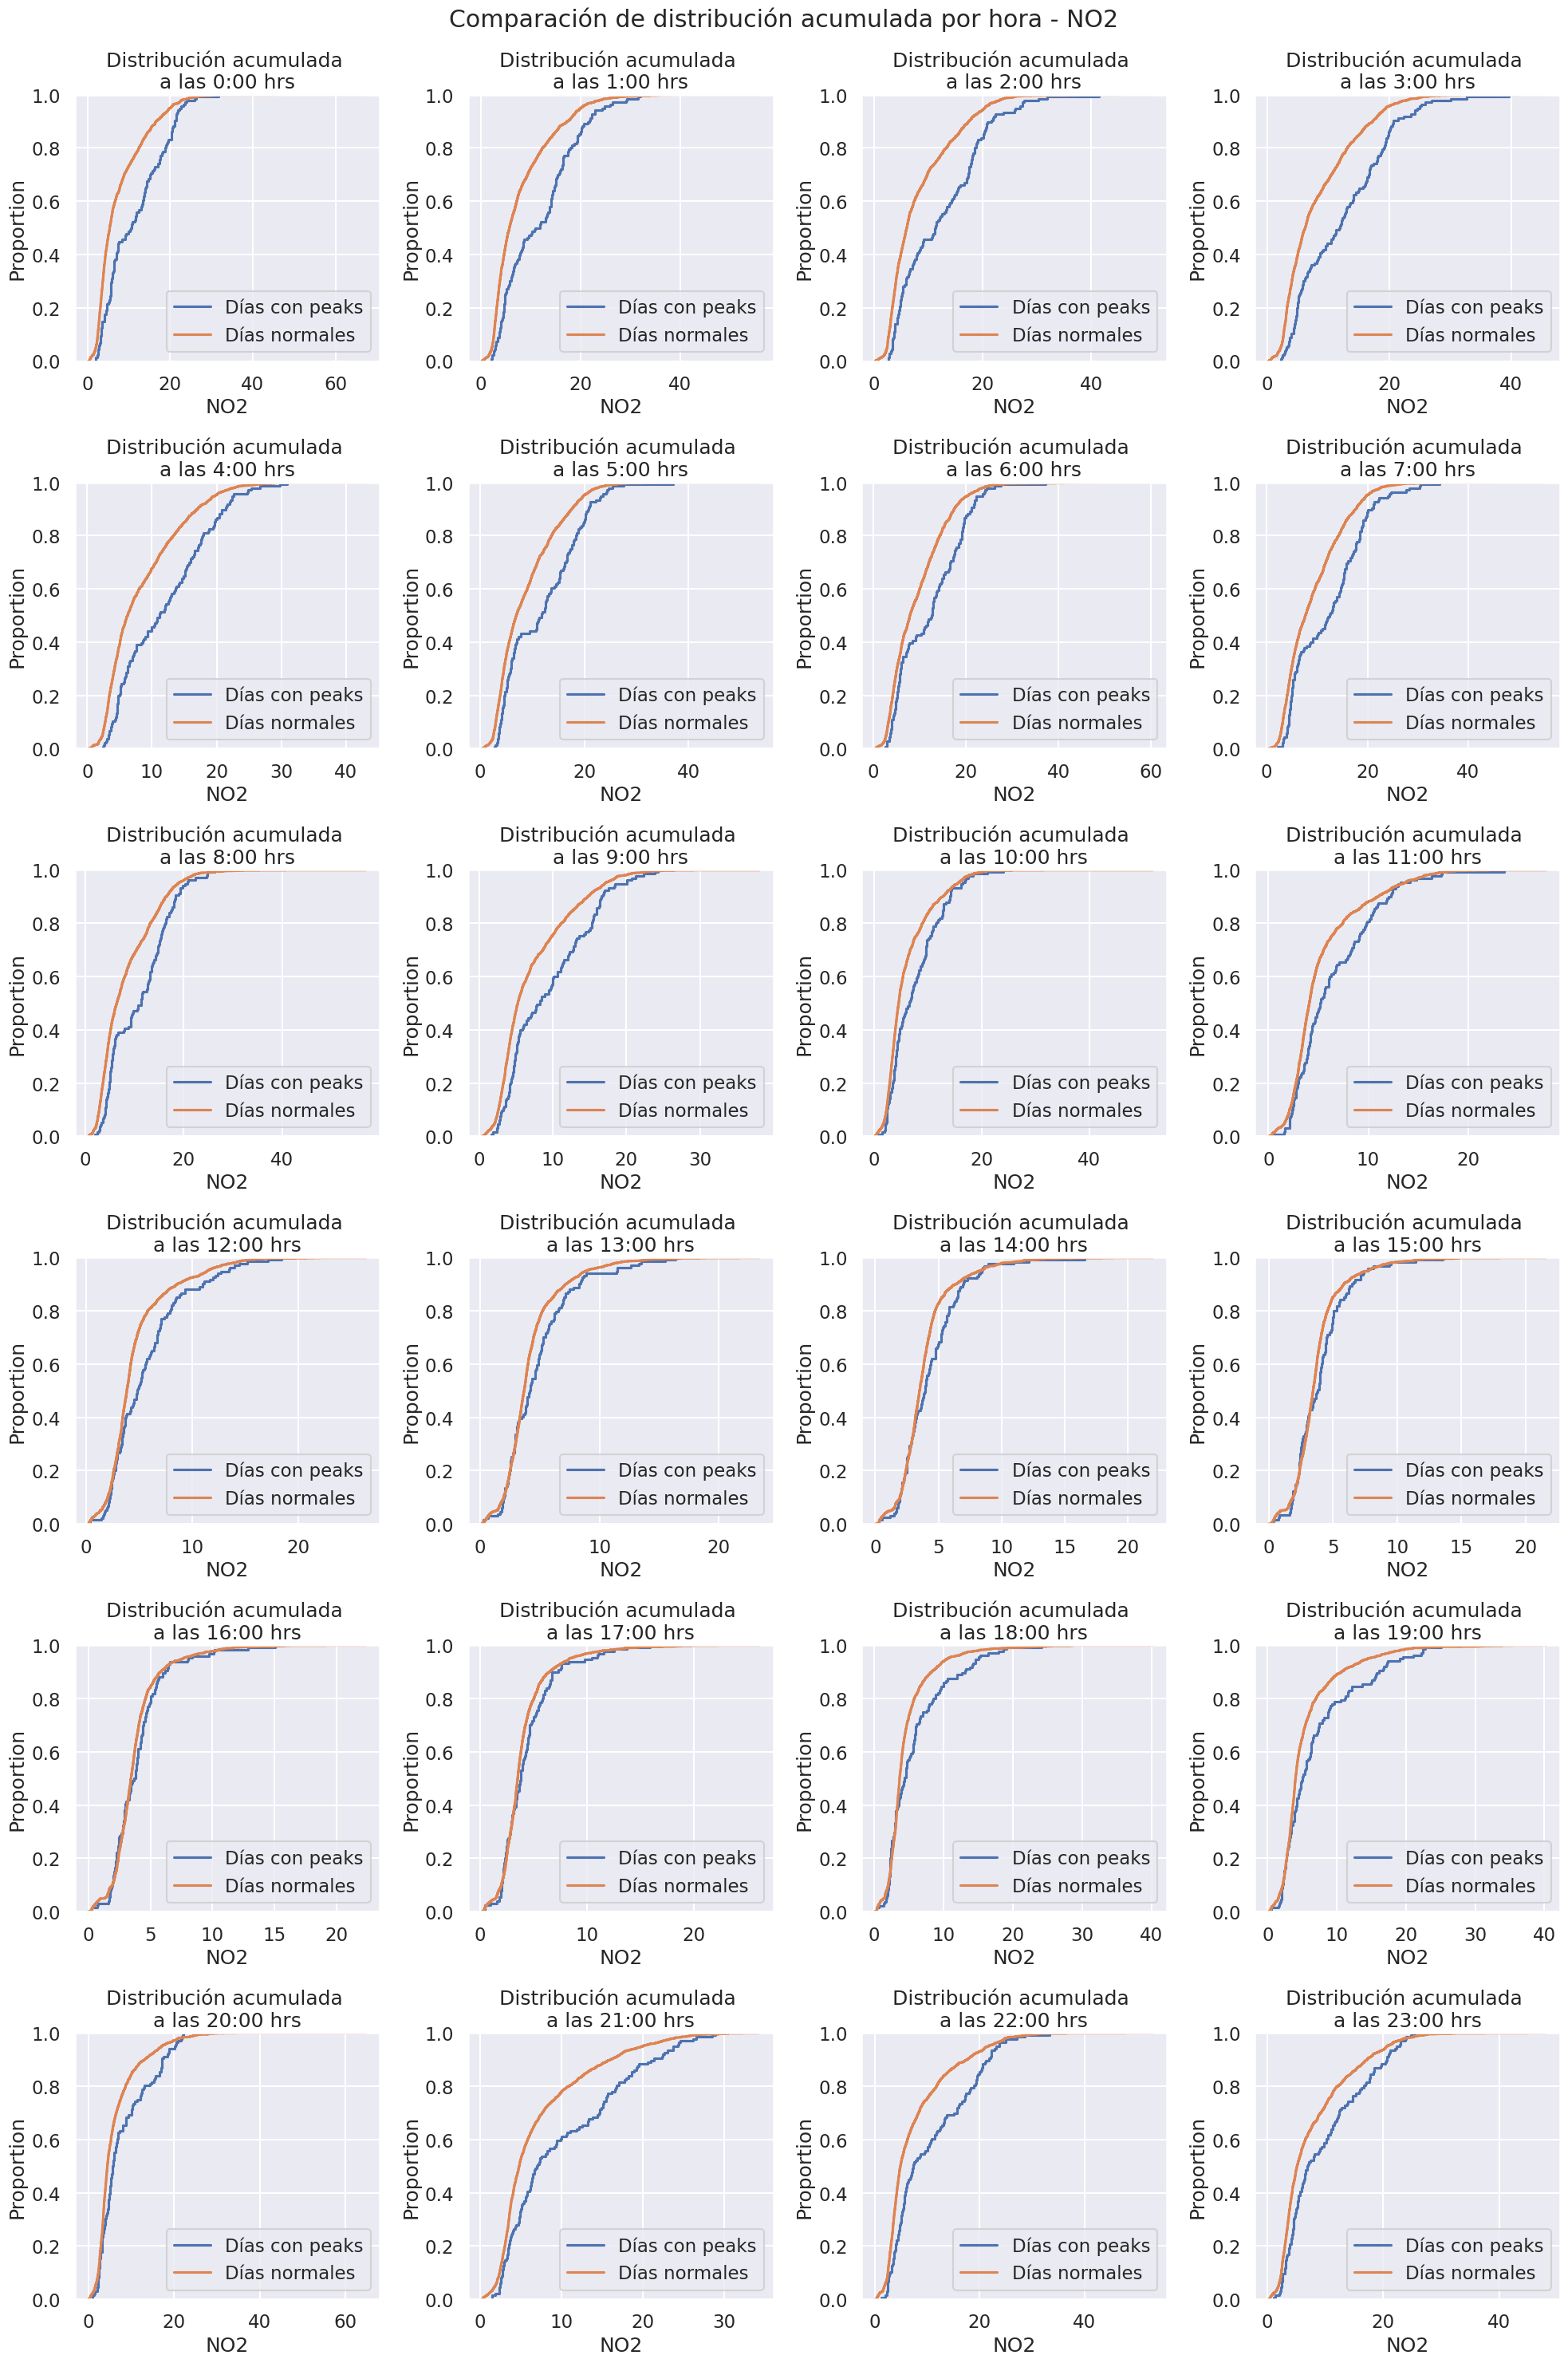

In [30]:
cumdistr_comparacion_horaria(peaks_df, limits50_df, 'Días con peaks', 'Días normales', 'NO2')

#### NOX

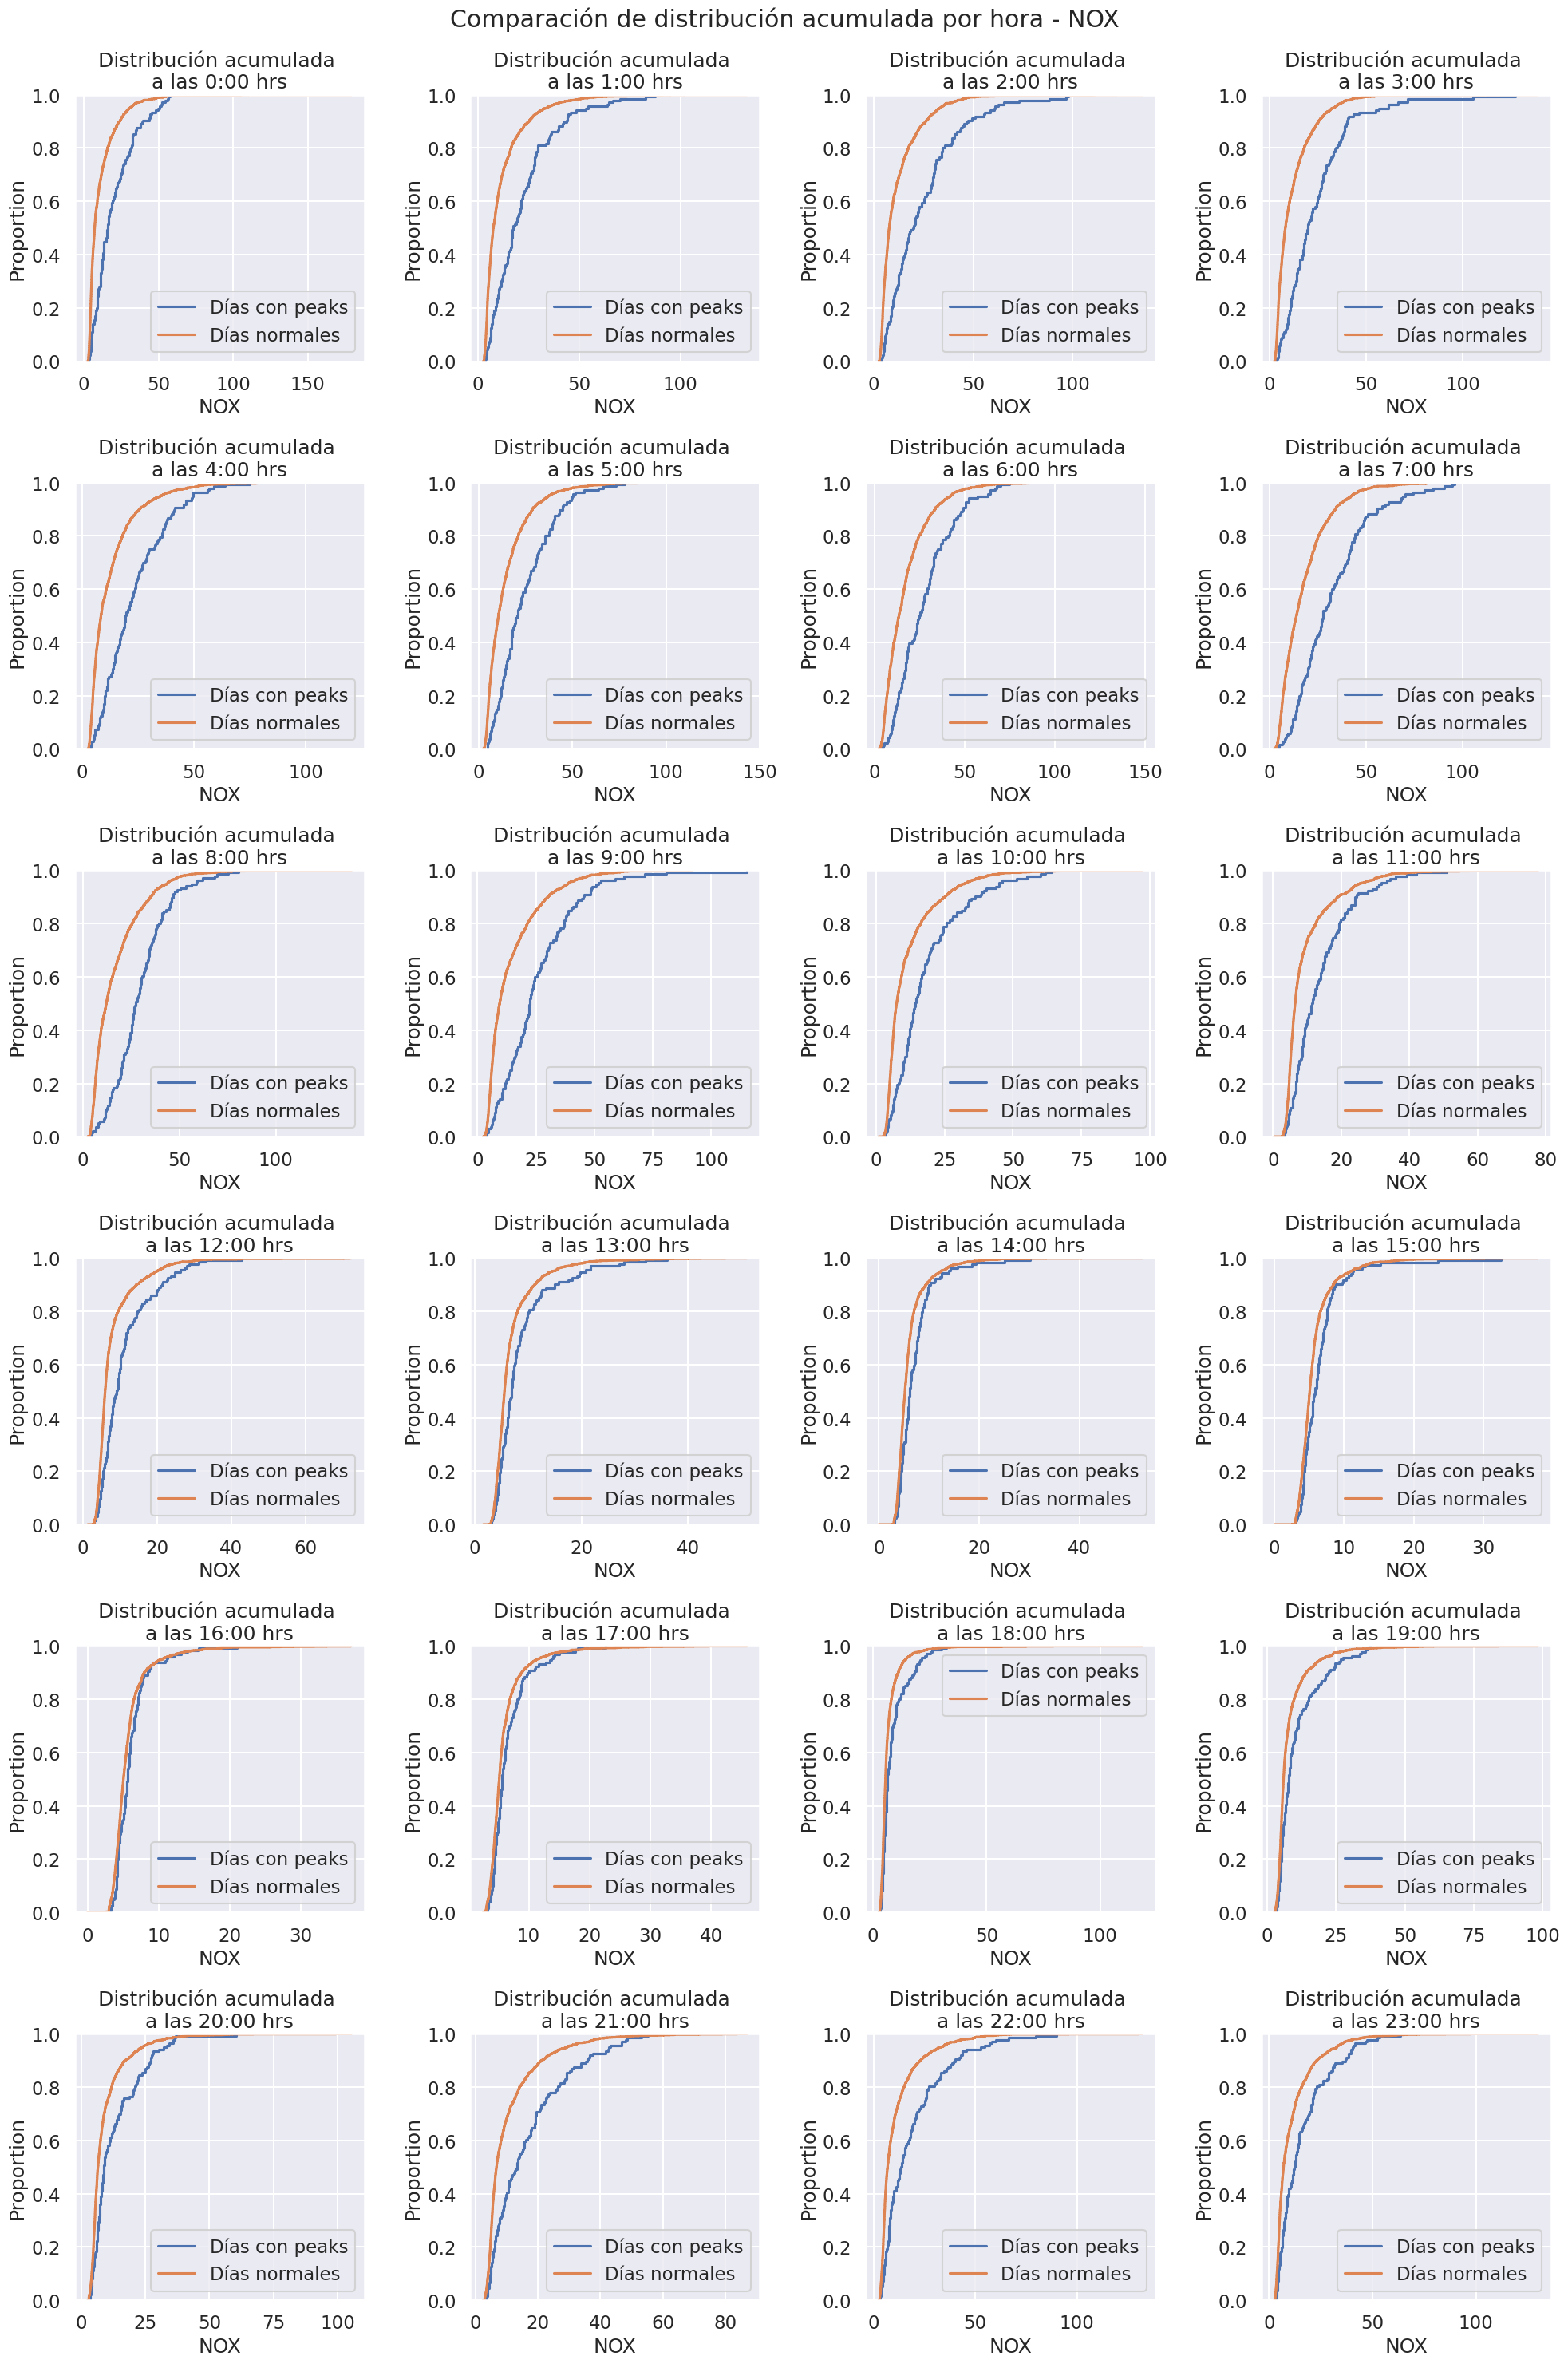

In [31]:
cumdistr_comparacion_horaria(peaks_df, limits50_df, 'Días con peaks', 'Días normales', 'NOX')